# Прогноз здоровья плода с помощью машинного обучения. Описание проекта.

Ссылка на Kaggle:
https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification


**Оригинальное описание проекта.**
Context
Reduction of child mortality is reflected in several of the United Nations' Sustainable Development Goals and is a key indicator of human progress.
The UN expects that by 2030, countries end preventable deaths of newborns and children under 5 years of age, with all countries aiming to reduce under‑5 mortality to at least as low as 25 per 1,000 live births.

Parallel to notion of child mortality is of course maternal mortality, which accounts for 295 000 deaths during and following pregnancy and childbirth (as of 2017). The vast majority of these deaths (94%) occurred in low-resource settings, and most could have been prevented.

In light of what was mentioned above, Cardiotocograms (CTGs) are a simple and cost accessible option to assess fetal health, allowing healthcare professionals to take action in order to prevent child and maternal mortality. The equipment itself works by sending ultrasound pulses and reading its response, thus shedding light on fetal heart rate (FHR), fetal movements, uterine contractions and more.

Data
This dataset contains 2126 records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

- Normal (1)
- Suspect (2)
- Pathological (3)

**Моё описание проекта.**


Рассматриваемый набор данных содержит данные, используемые для оценки здоровья плода, полученные с помощью кардиотокограмм (CTG). Правильная оценка этих данных и верное определение состояния здоровья плода может помочь в вопросе снижения детской и материнской смертности, поэтому на основе них будет построена модель для предсказания здоровья плода по параметрам его кардиотограммы, т. е. решаться задача многоклассовой классификации. Применятся в нашем проекте для этого будут основные бустинговые модели: CatBoost, LightGBM, XGBoost.

Входные признаки:


- базальный ЧСС (baseline_value)
- акселерация (accelerations)
- движения плода (fetal_movement)
- сокращения матки в секунду (uterine_contractions)
- легкая децелерация (light_decelerations)
- тяжёлая децелерация (severe_decelerations)
- пролонгированная децелерация (prolongued_decelerations)
- вариабельность ритма STV (abnormal_short_term_variability)
- среднее значение вариабельности STV (mean_value_of_short_term_variability)
- процент времени с вариабельностью LTV (percentage_of_time_with_abnormal_long_term_variability)
- среднее значение LTV (mean_value_of_long_term_variability)
- ширина гистограммы (histogram_width)
- минимальное значение гистограммы (histogram_min)
- максимальное значение гистограммы (histogram_max)
- число пиков в гистограмме (histogram_number_of_peaks)
- число нулей в гистограмме (histogram_number_of_zeroes)
- мода гистограммы (histogram_mode)
- среднеарифметическое гистограммы (histogram_mean)
- медиана гистограммы (histogram_median)
- дисперсия гистограммы (histogram_variance)
- тренд гистограммы (histogram_tendency)

Целевой признак:
- класс здоровья(fetal_health, 1 - нормальный, 2 - пограничный, 3 - патологический)

Рассматриваемая метрика: F-Beta.

# Загрузка и анализ данных.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загружаем необходимые библиотеки.

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    make_scorer,
    fbeta_score,
    confusion_matrix
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    KFold
)

!pip install catboost
from catboost import CatBoostClassifier

import lightgbm as lgbm

from xgboost import XGBClassifier

Загружаем данные.

In [7]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fetal_health.csv", sep=",")

Фиксируем значение для Random State.

In [8]:
RND_STATE = 42

Смотрим информацию о нашем датафрейме.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [10]:
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


Смотрим колиство дубликатов.

In [12]:
df.duplicated().sum()

13

Удаляем дубликаты.

In [13]:
df = df.drop_duplicates()

Строим гистограммы для входных признаков.

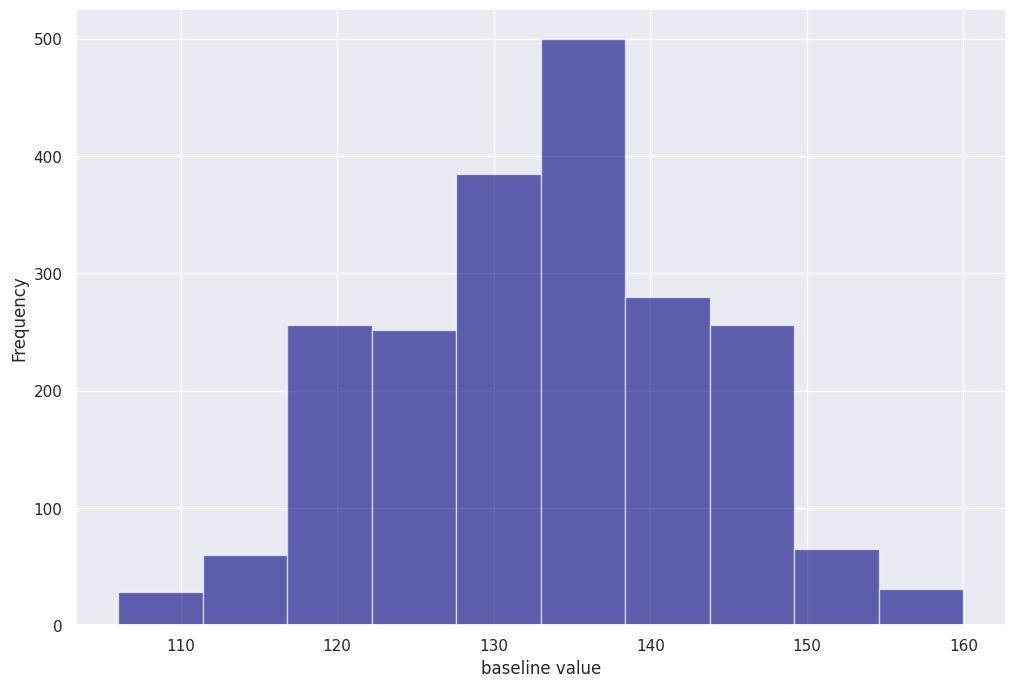

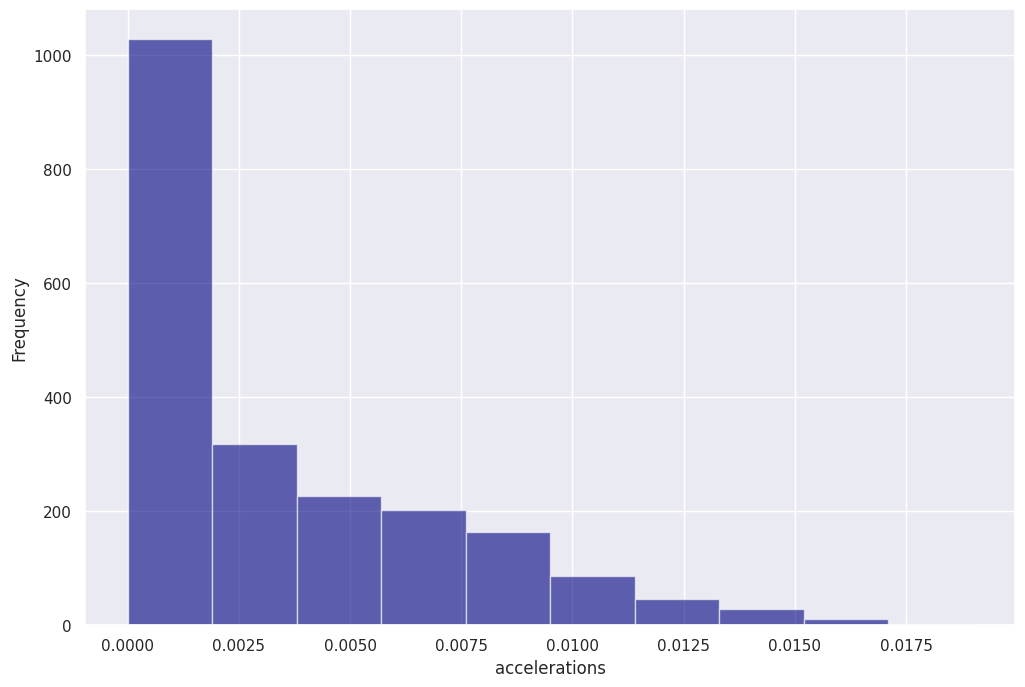

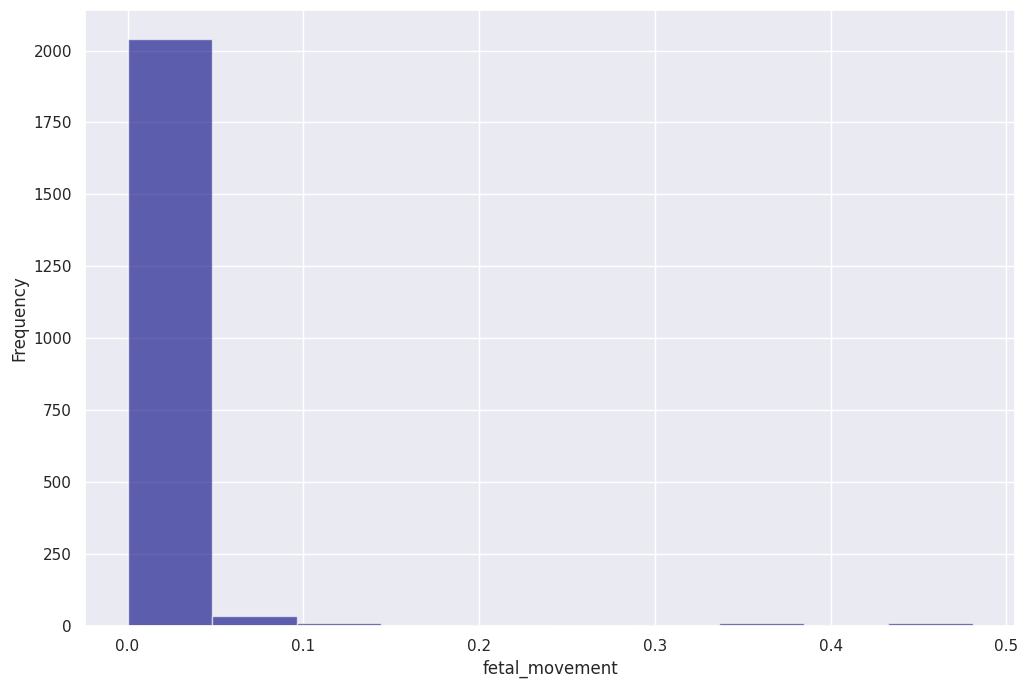

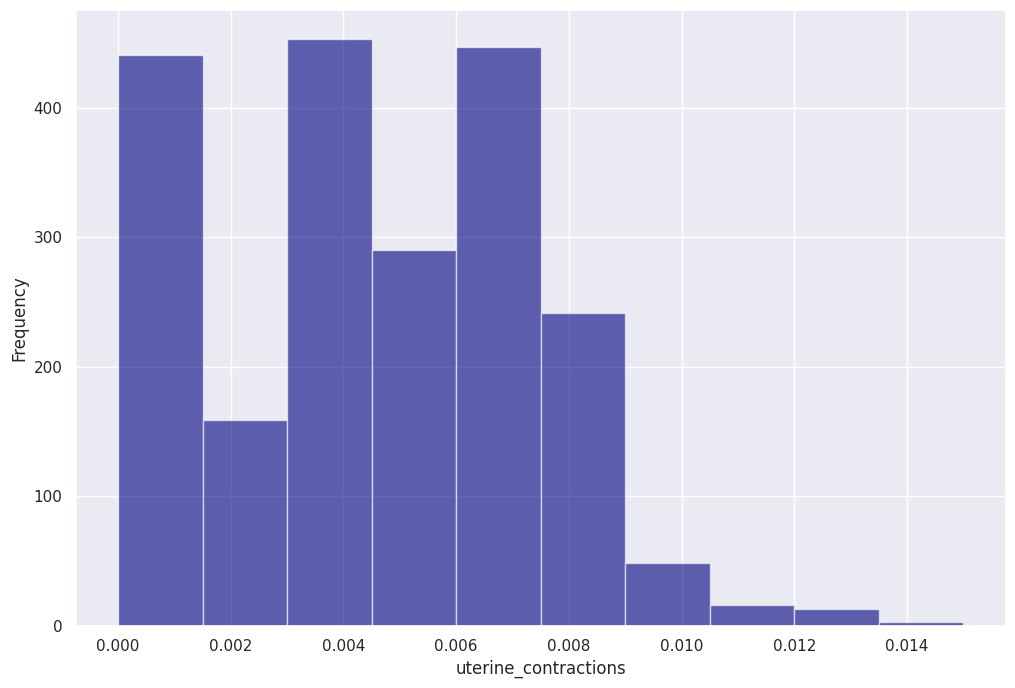

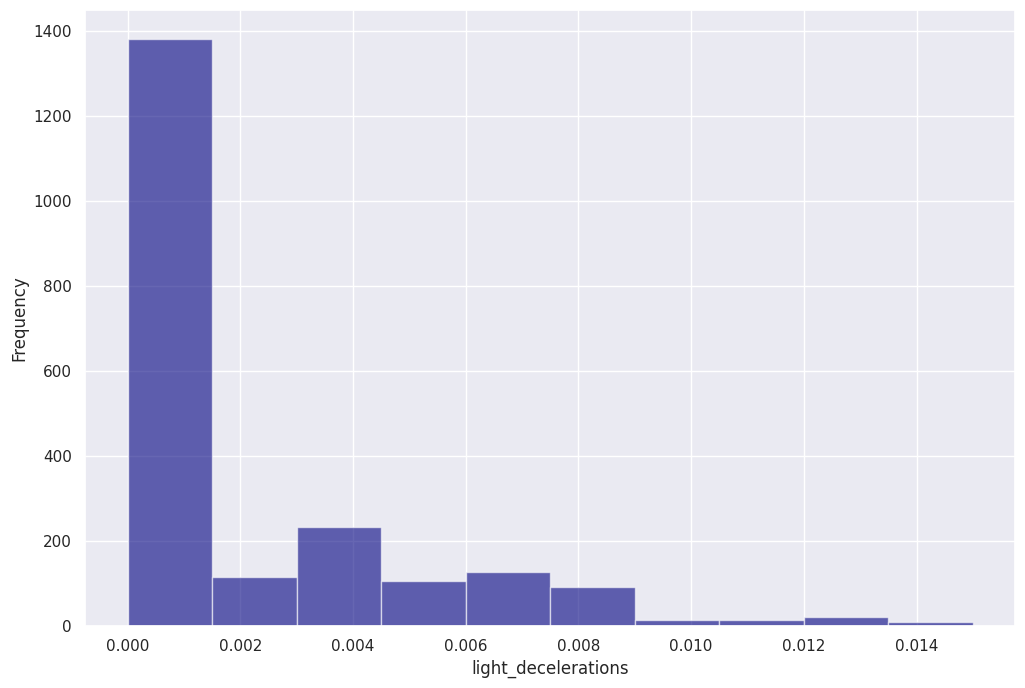

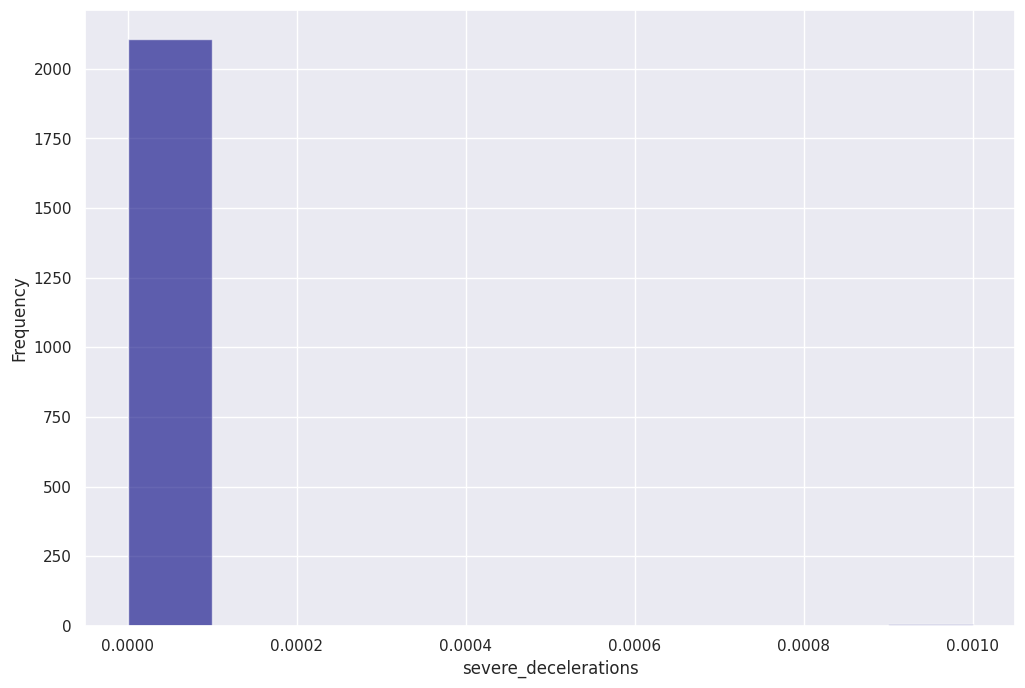

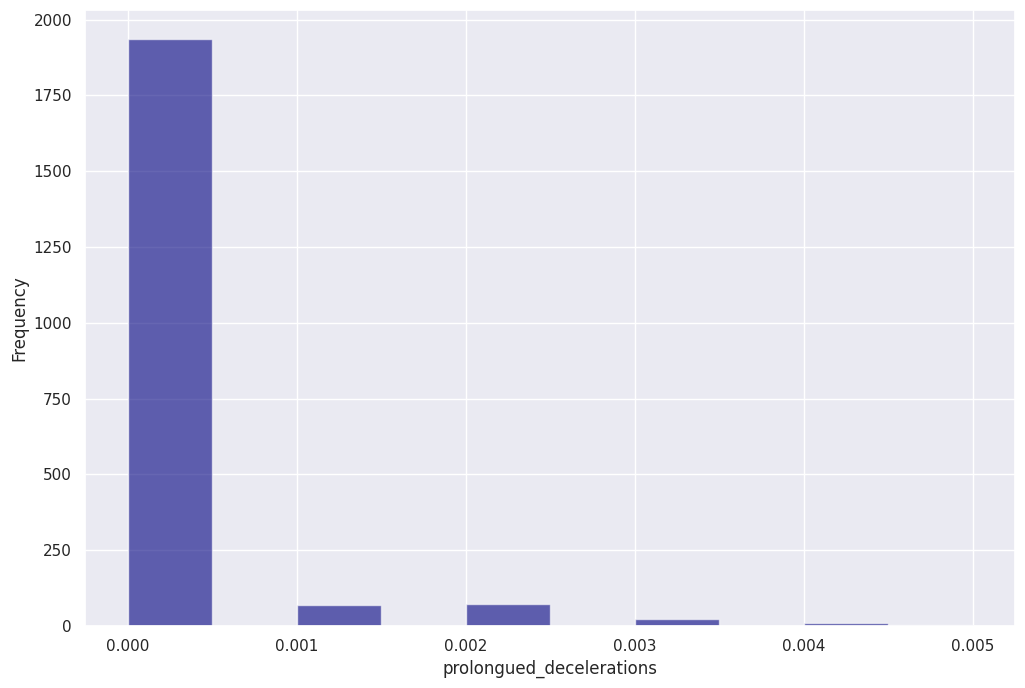

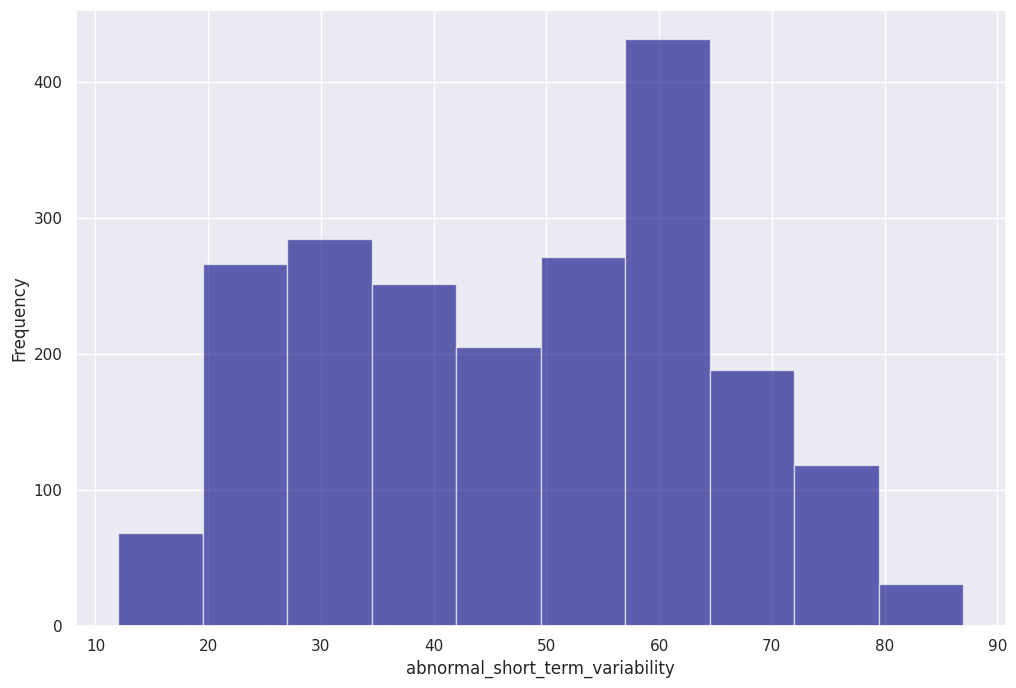

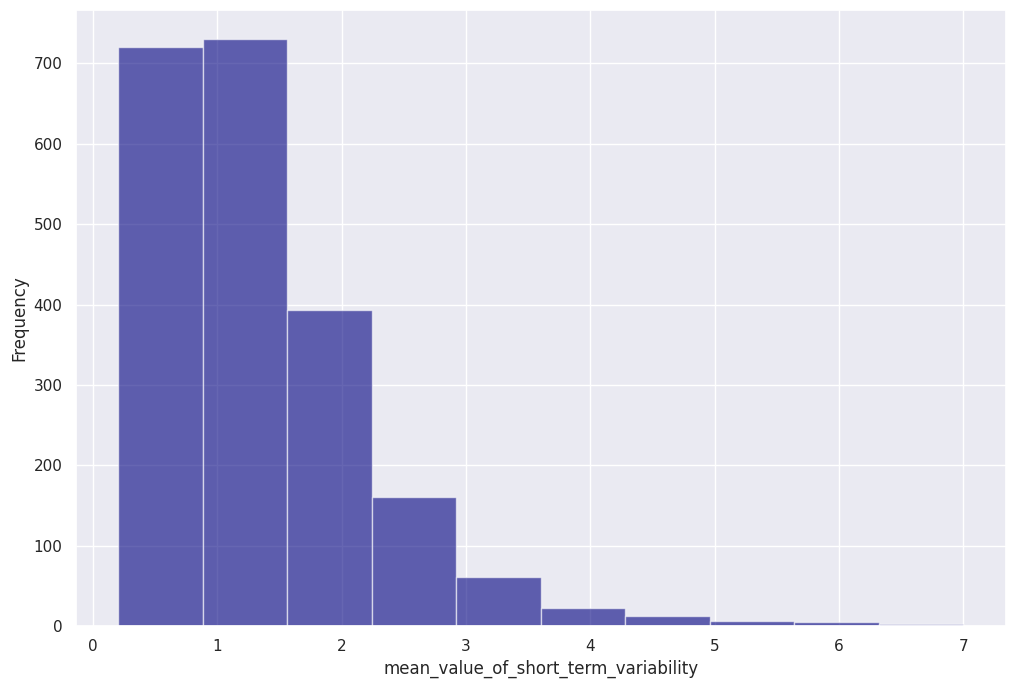

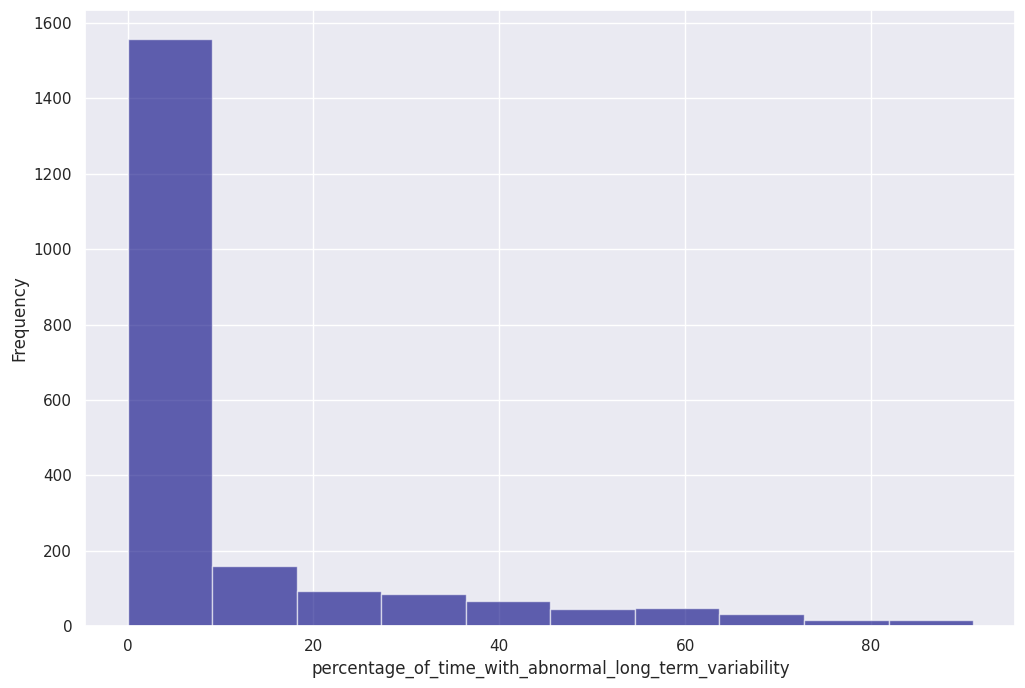

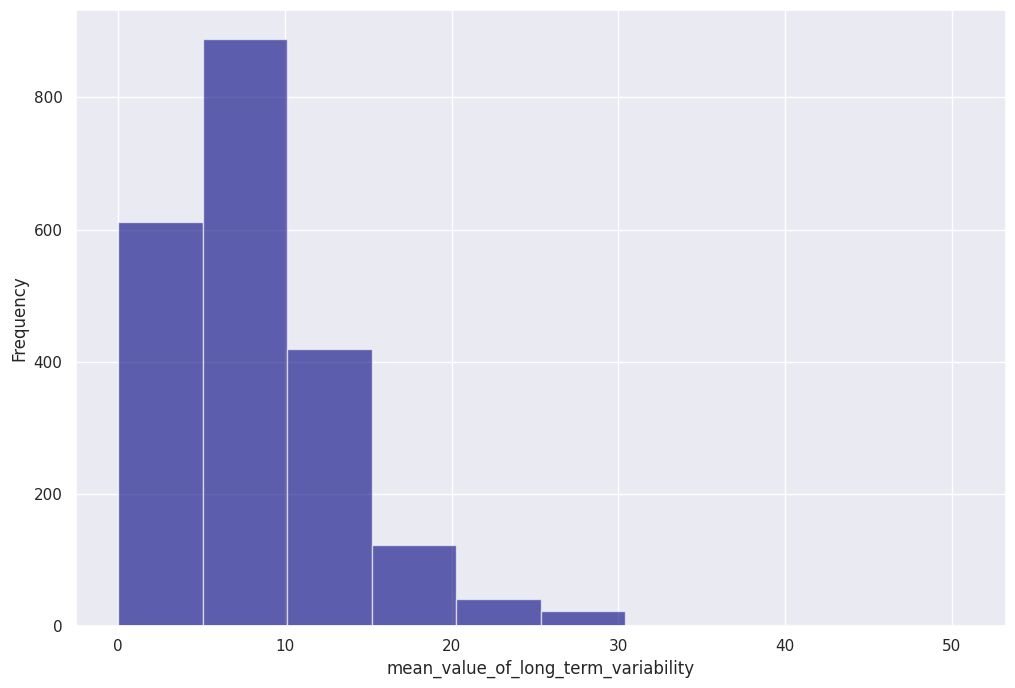

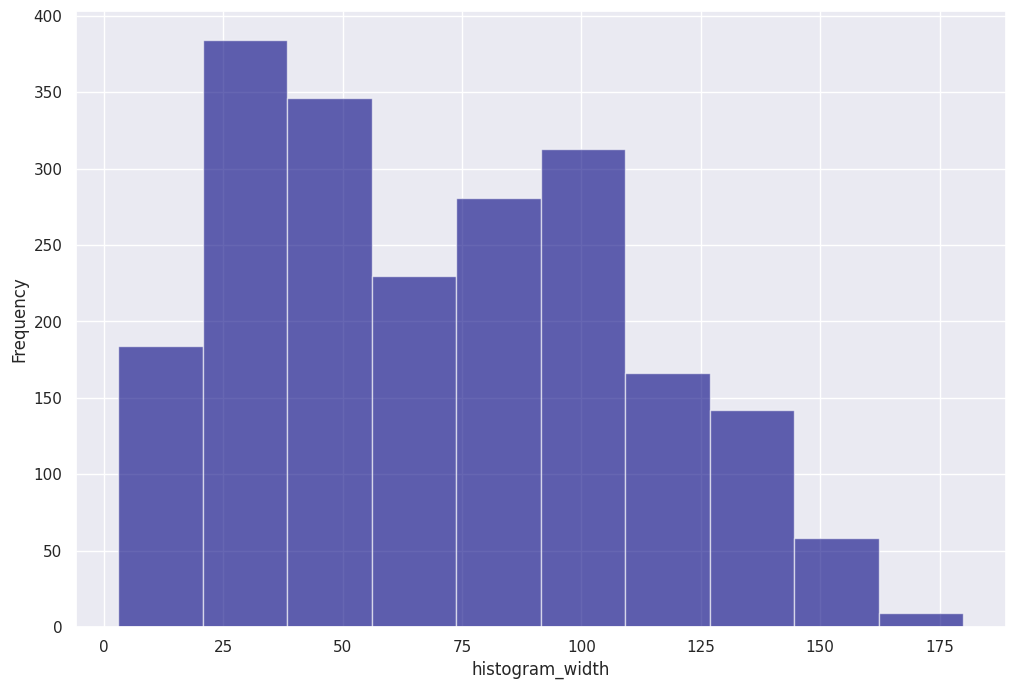

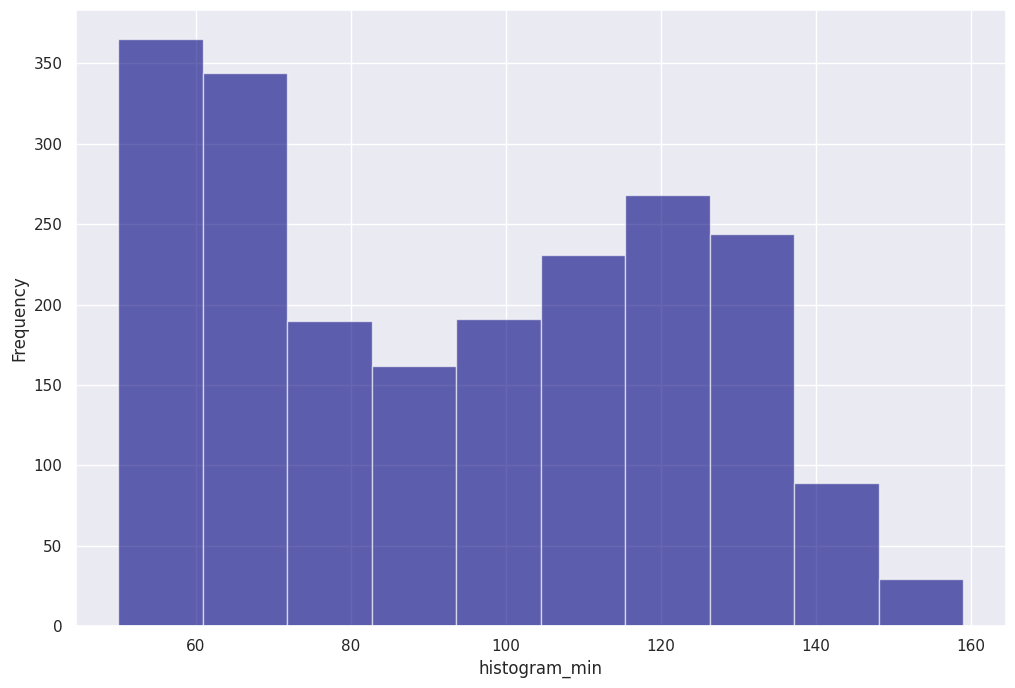

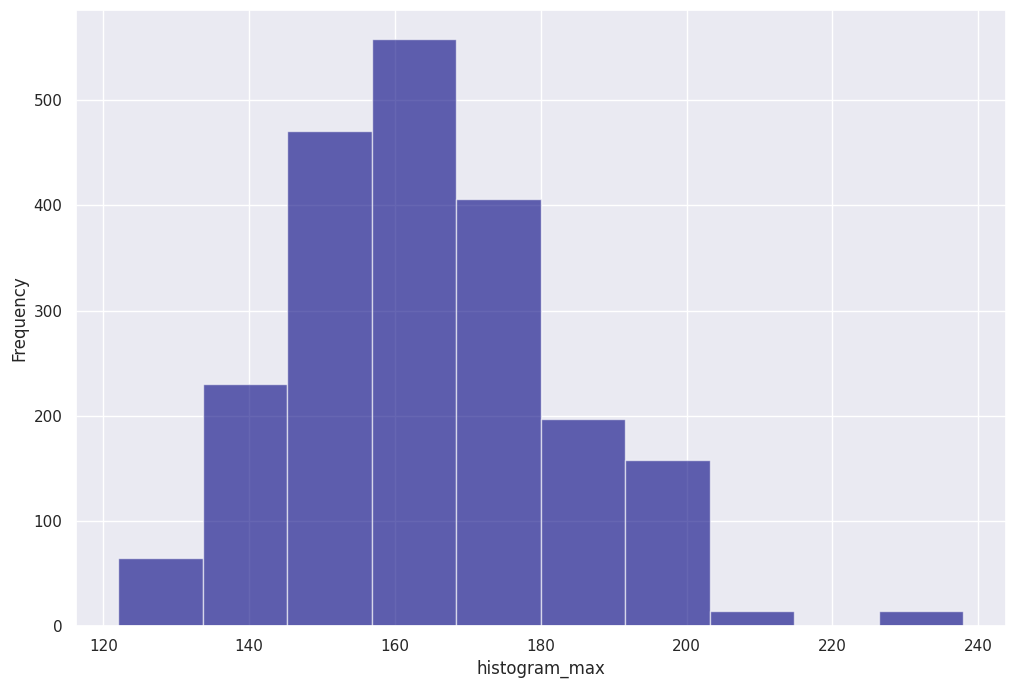

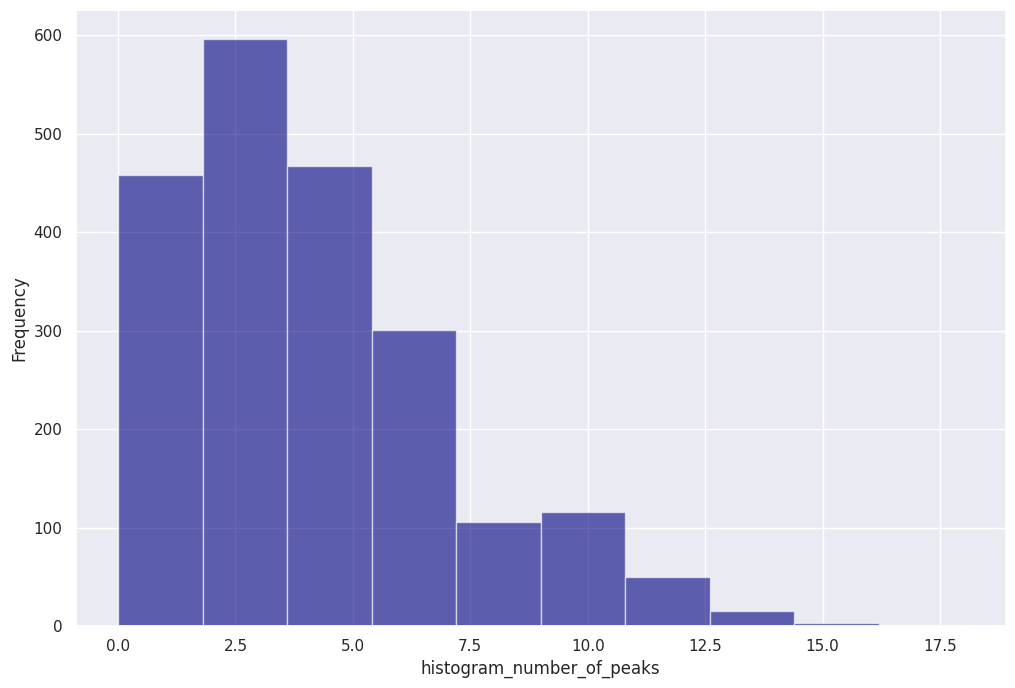

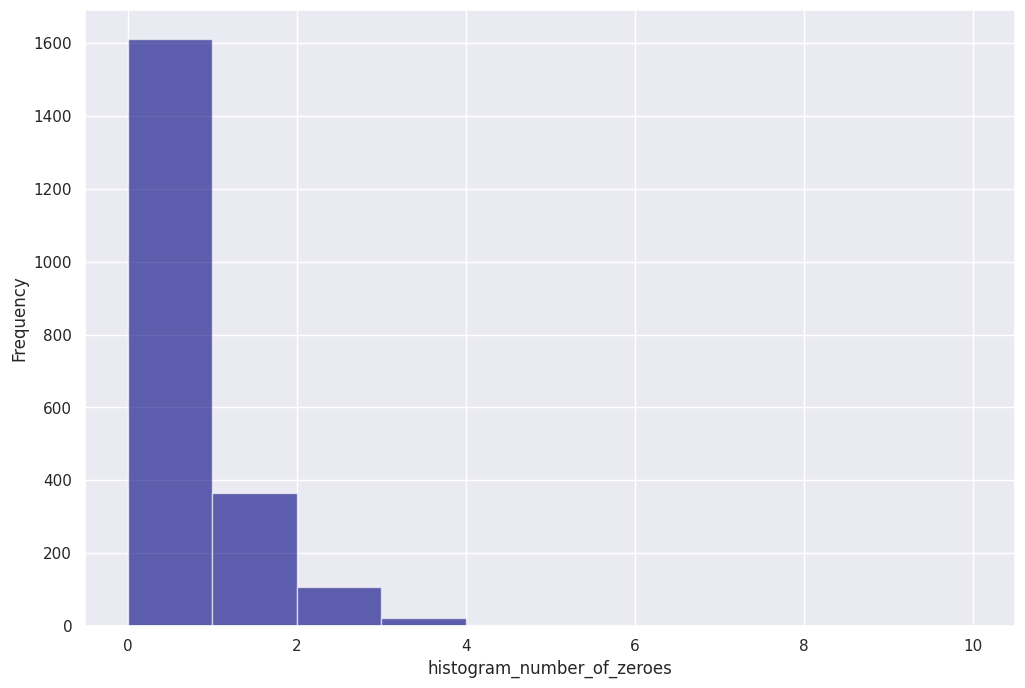

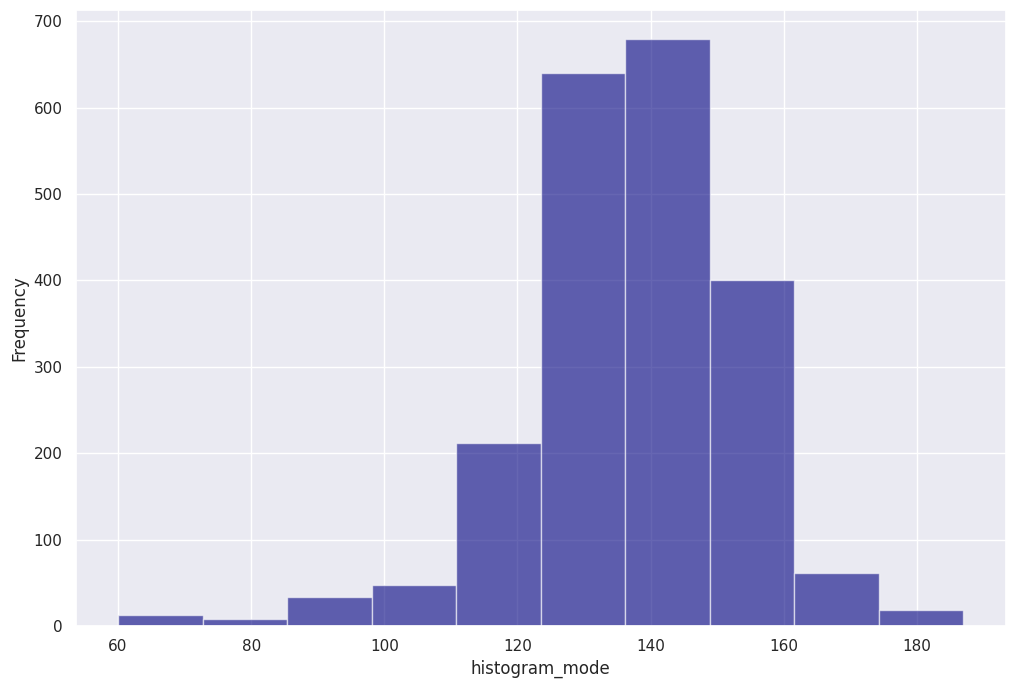

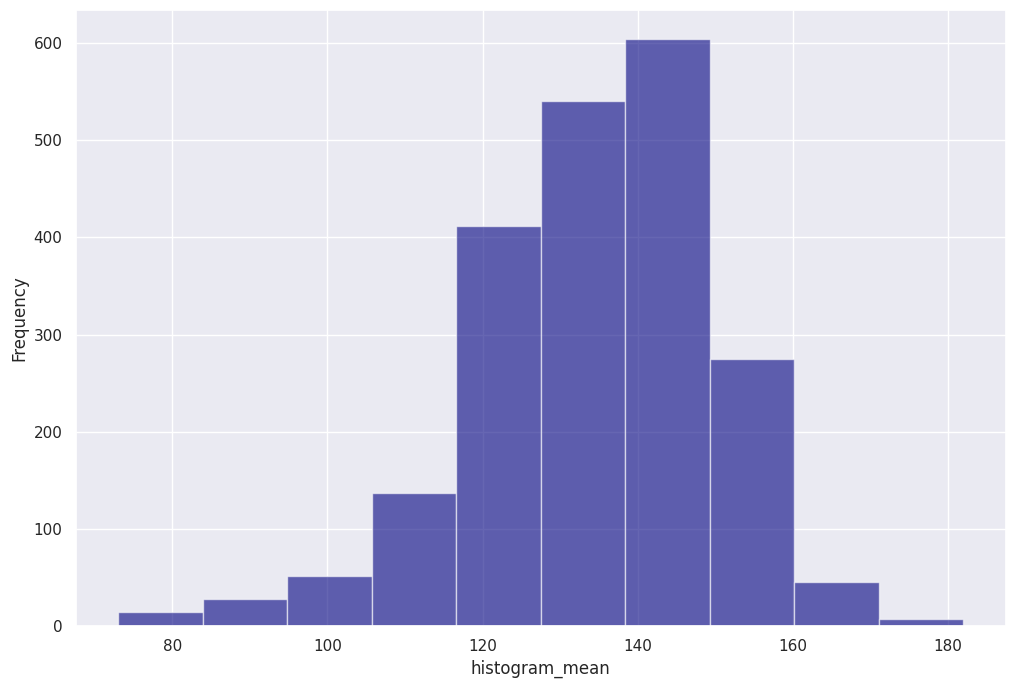

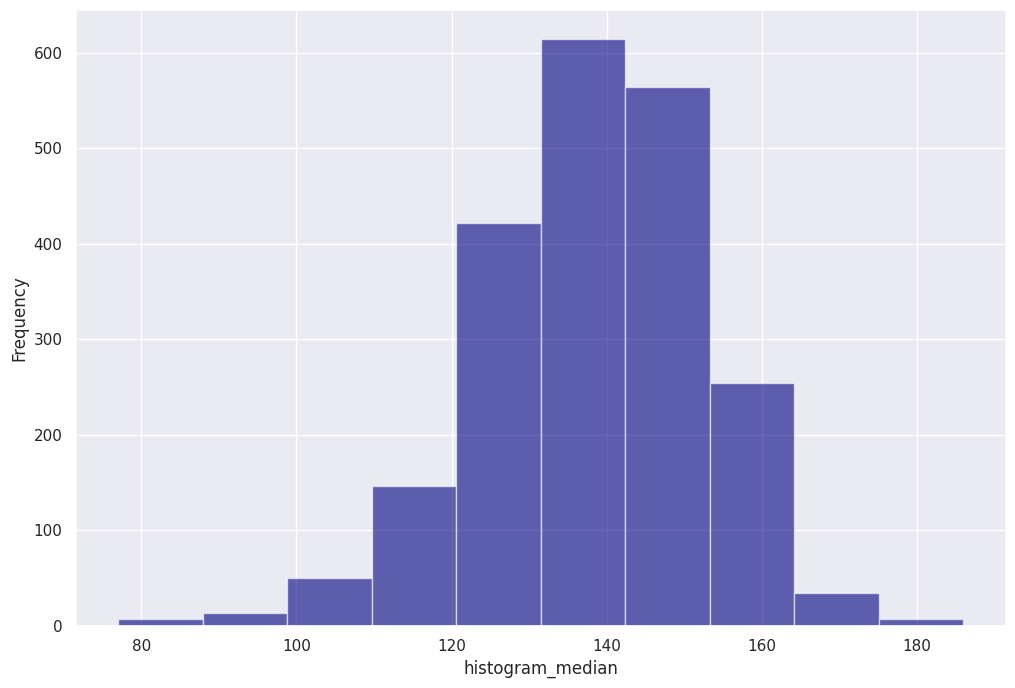

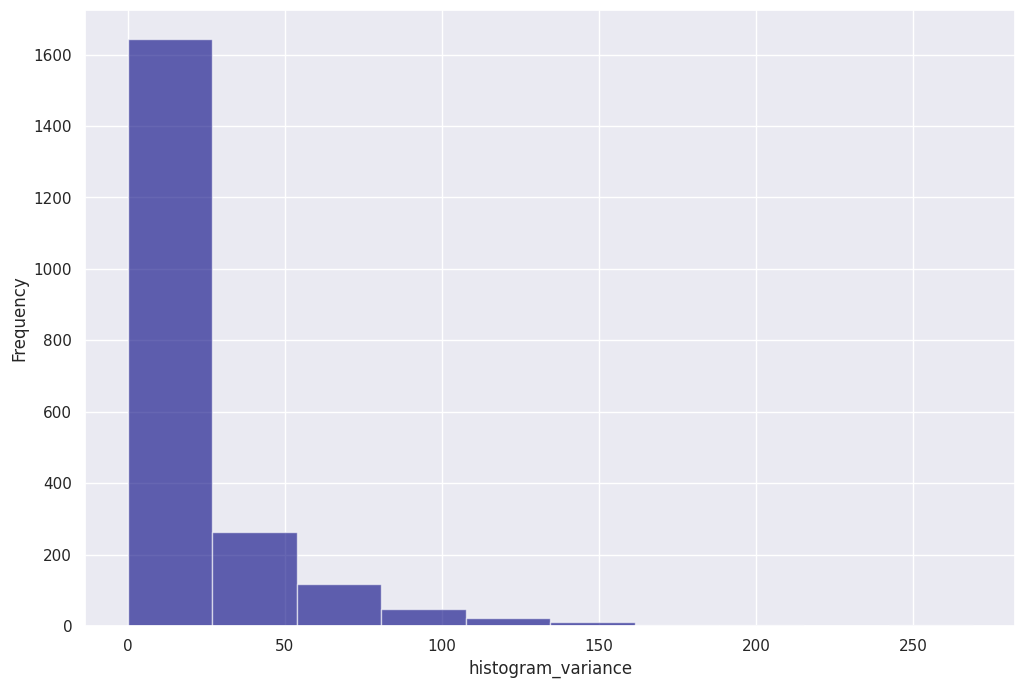

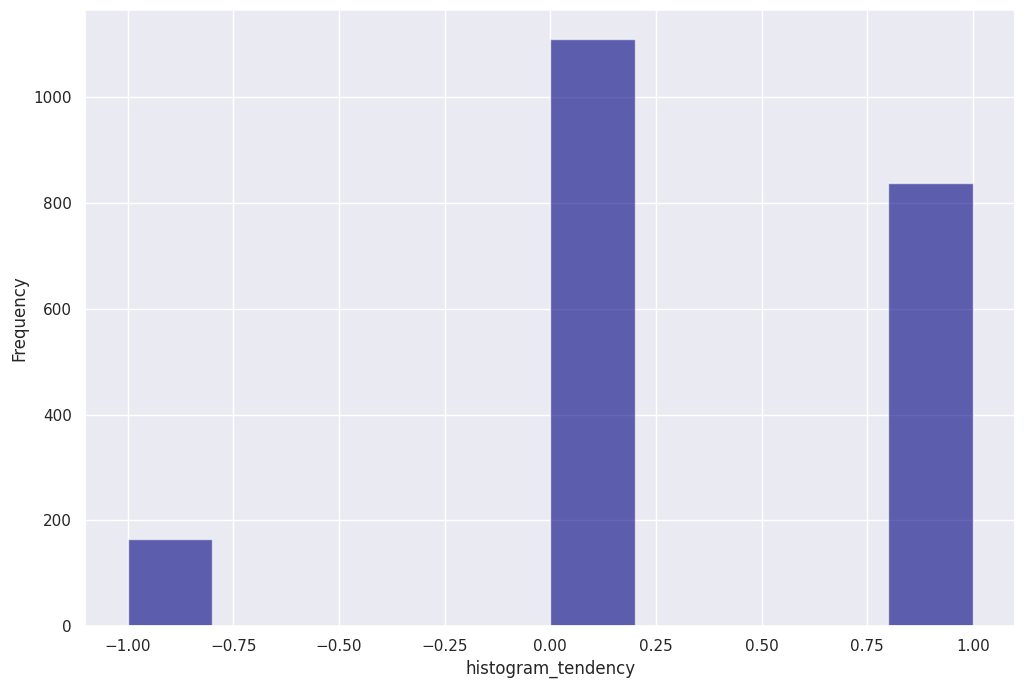

In [14]:
features_list = [col for col in df.columns if col != 'fetal_health']

for feature in features_list:
    sns.set(rc={'figure.figsize':(12, 8)})
    df[feature].plot(kind='hist', color='navy', alpha=0.6)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()
    print('')

Видим, что значения параметров различаются по распределению.

Аналогично строим диаграммы размаха.

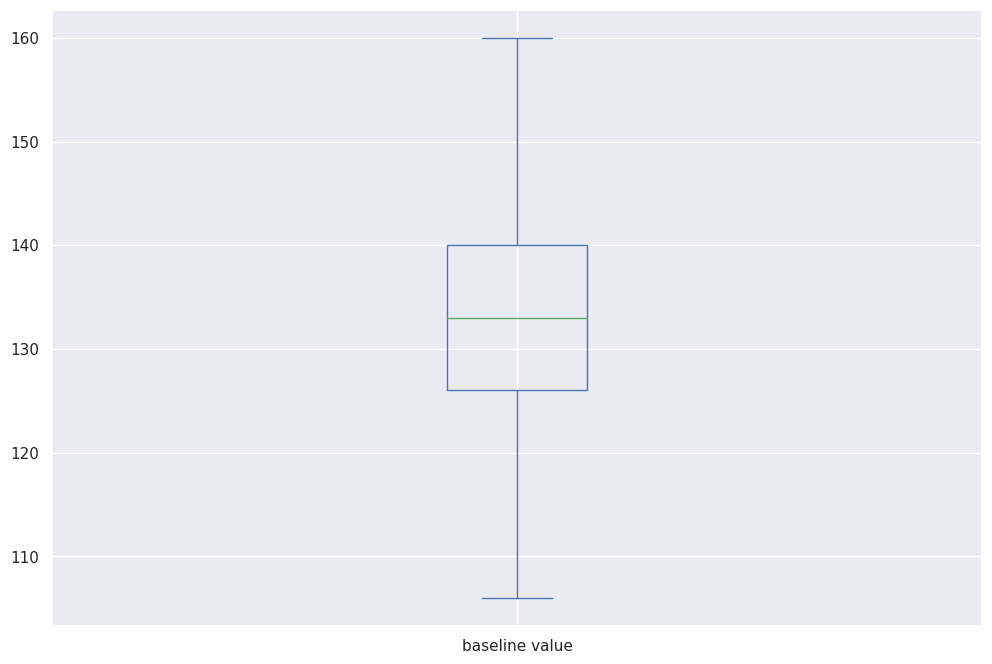

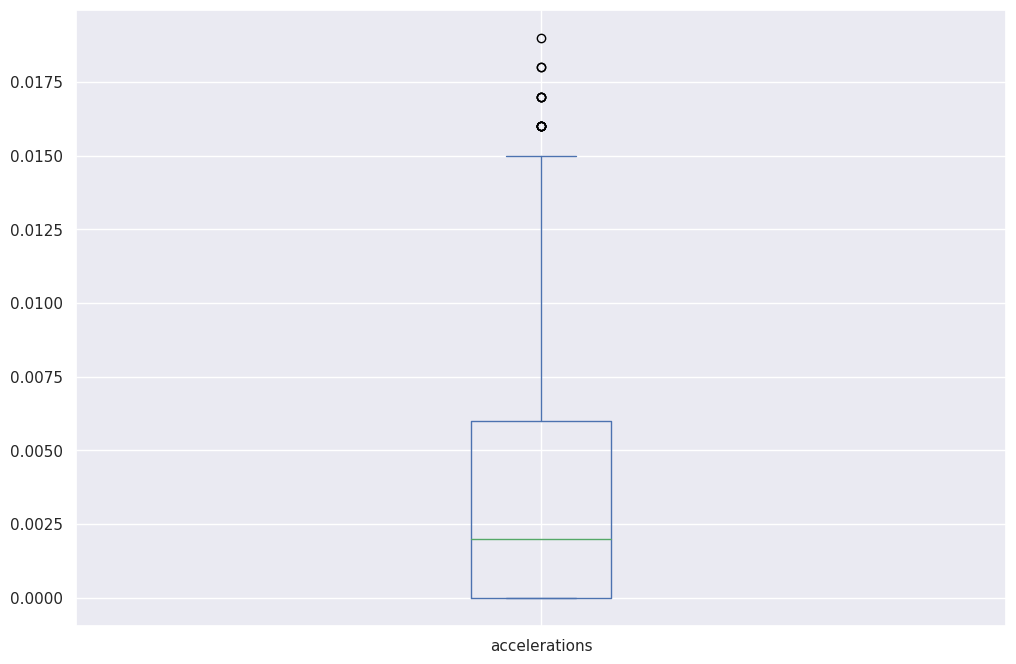

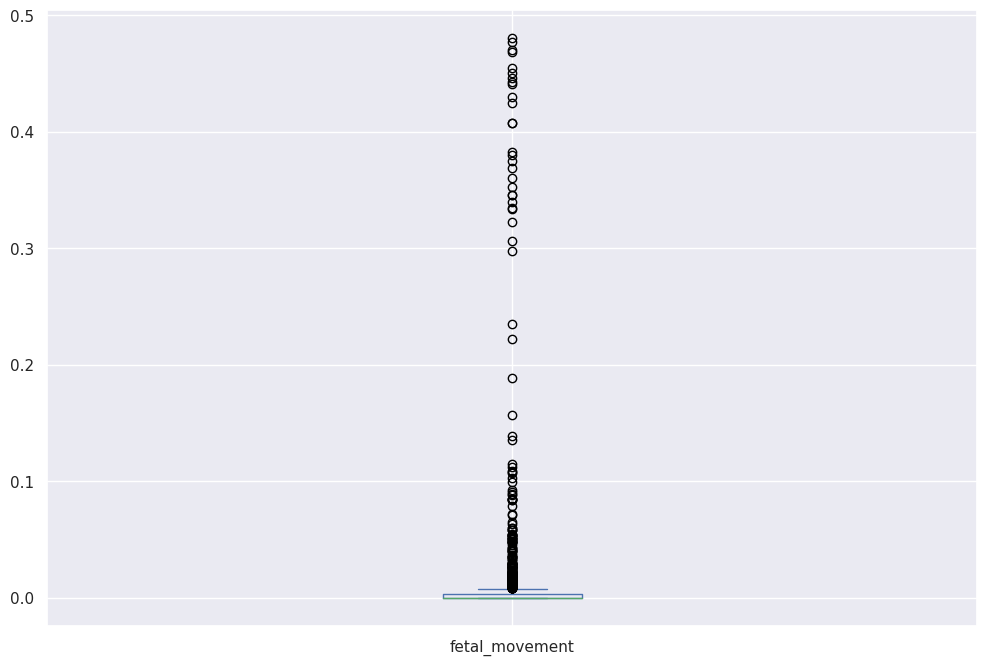

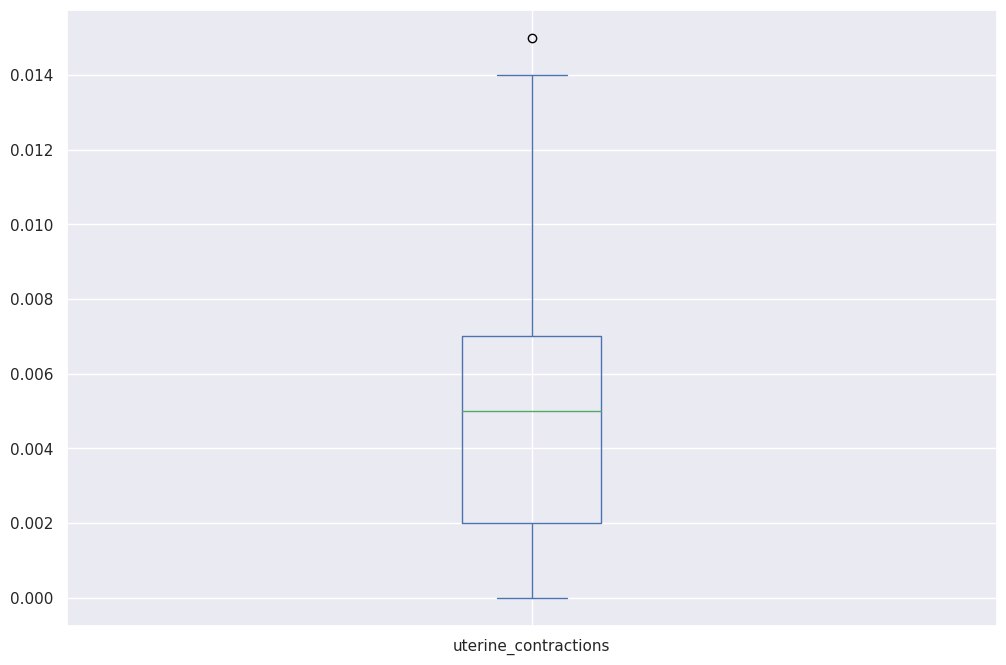

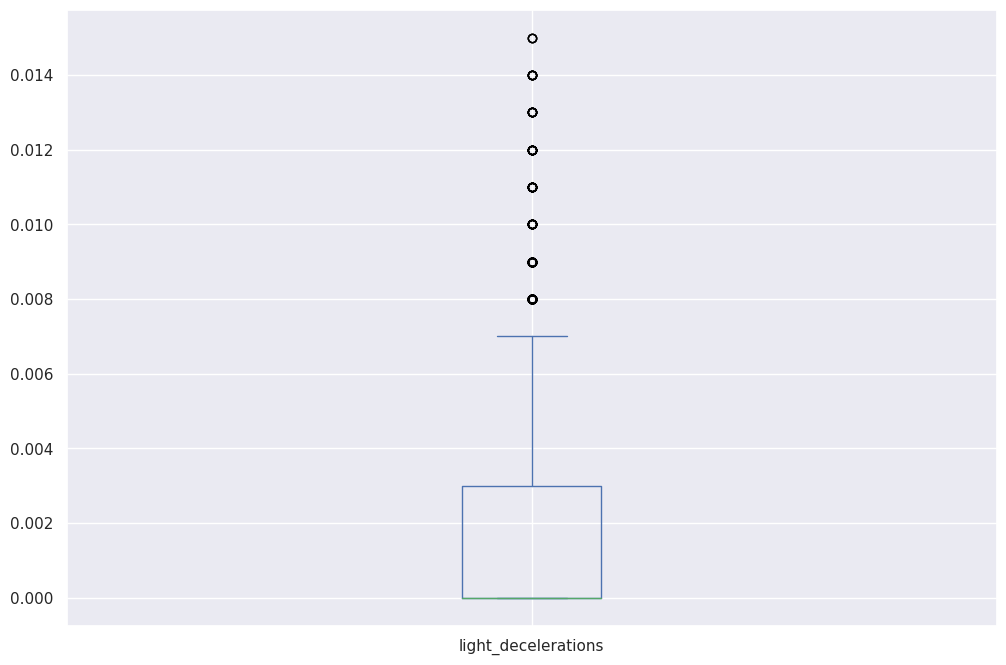

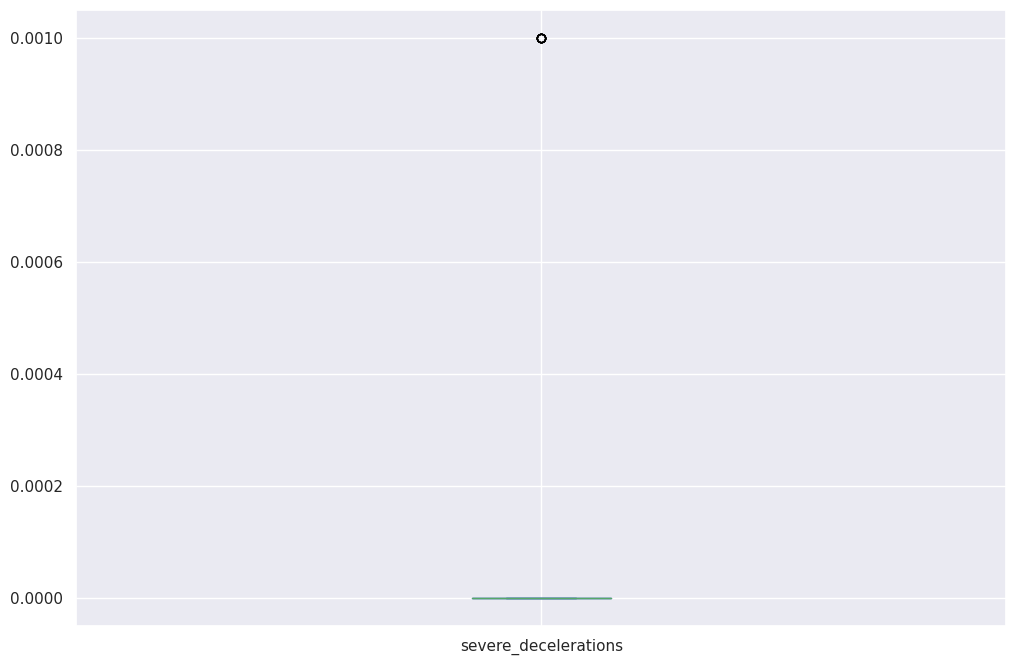

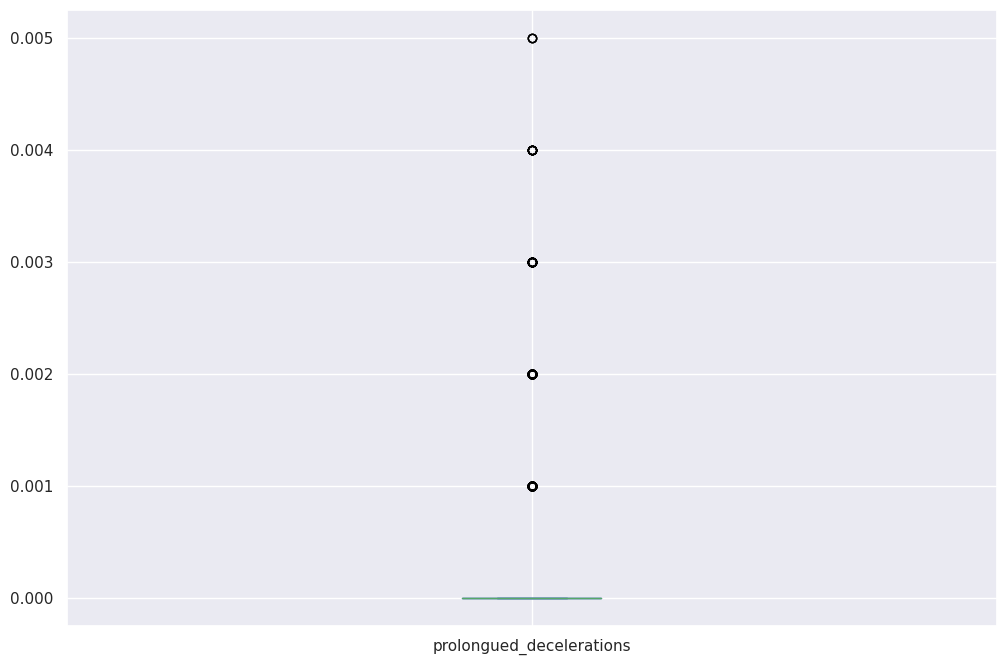

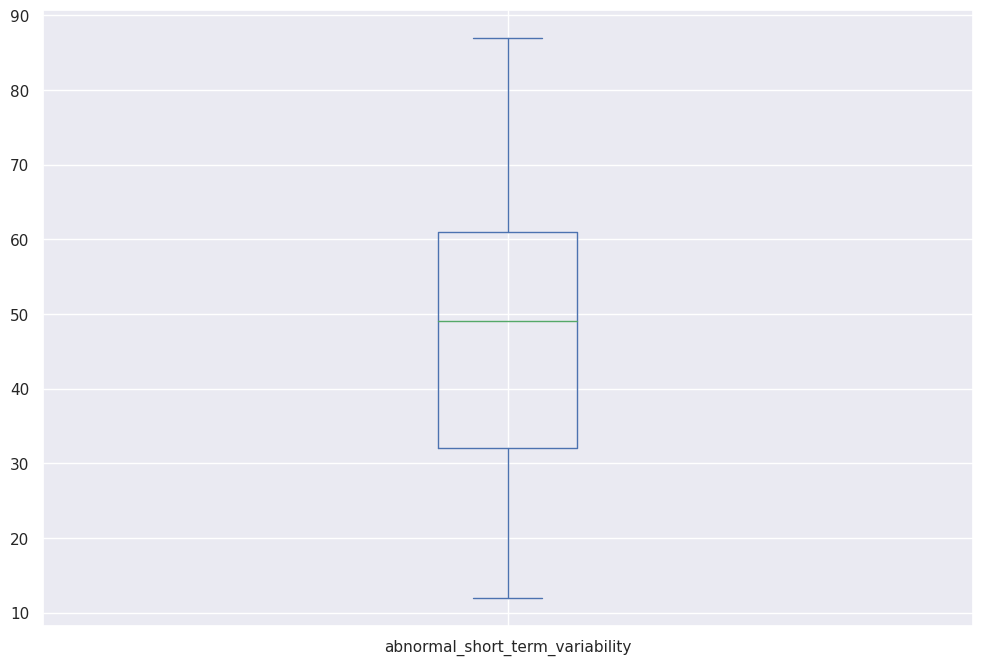

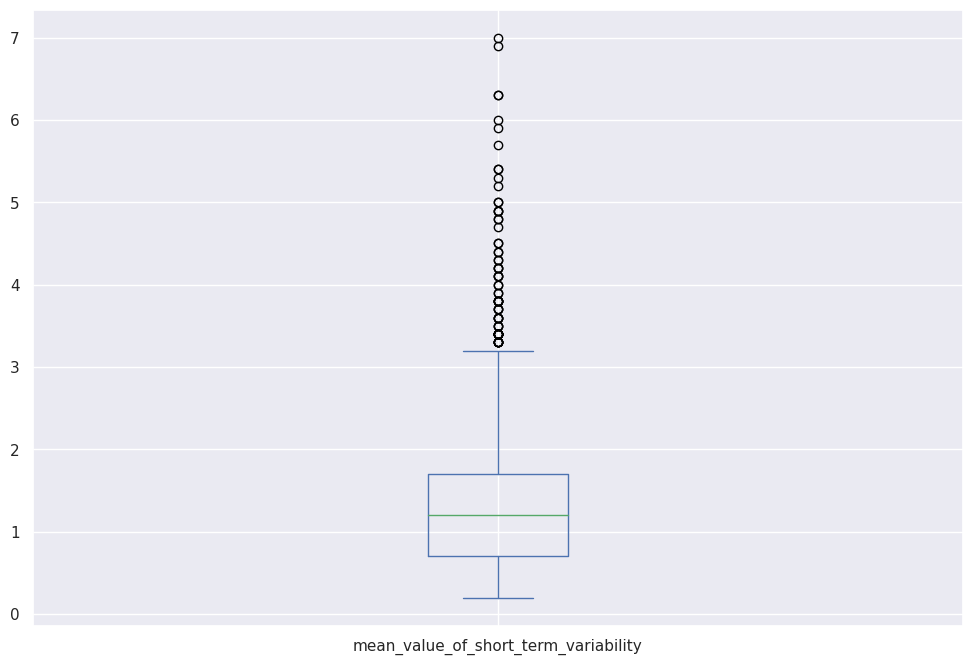

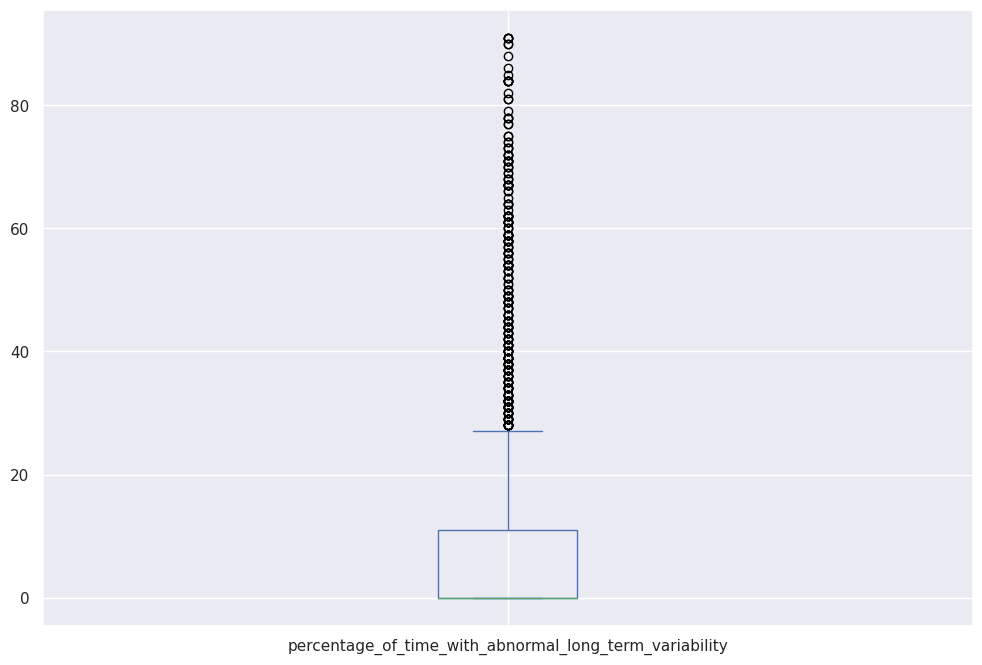

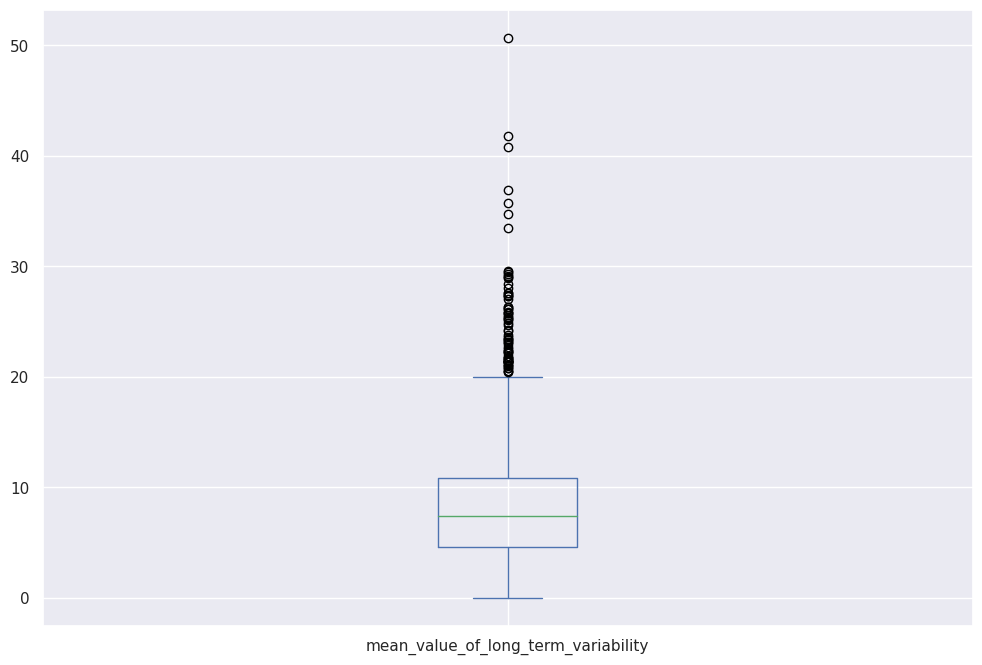

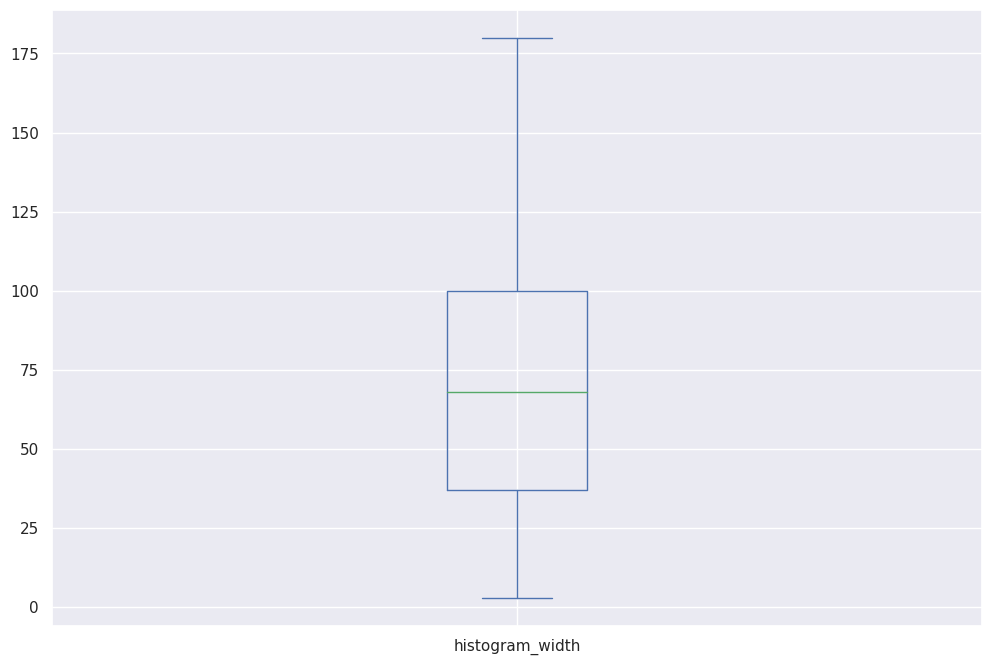

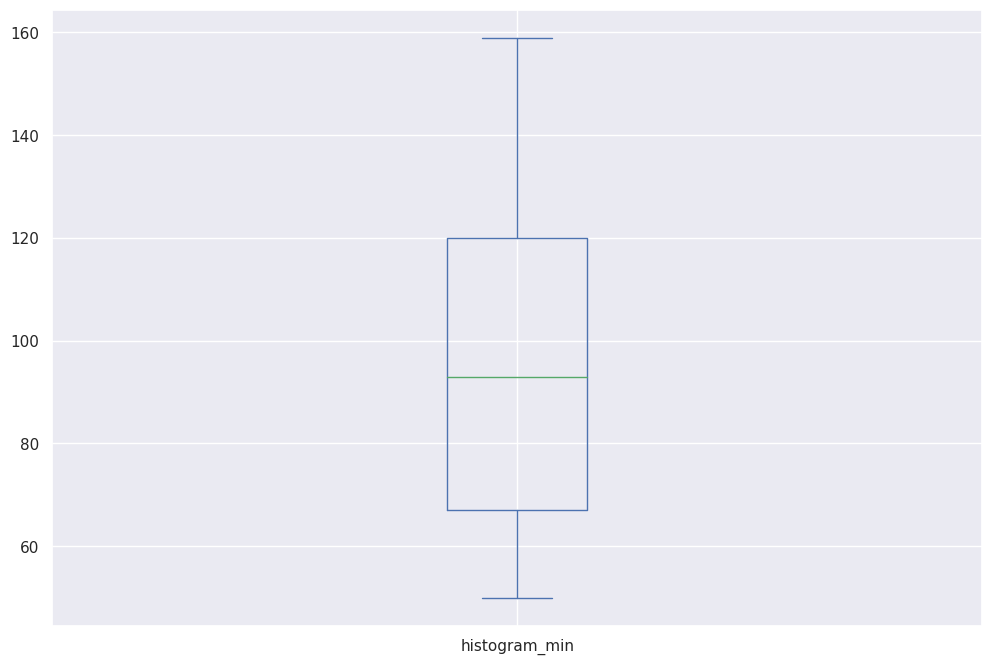

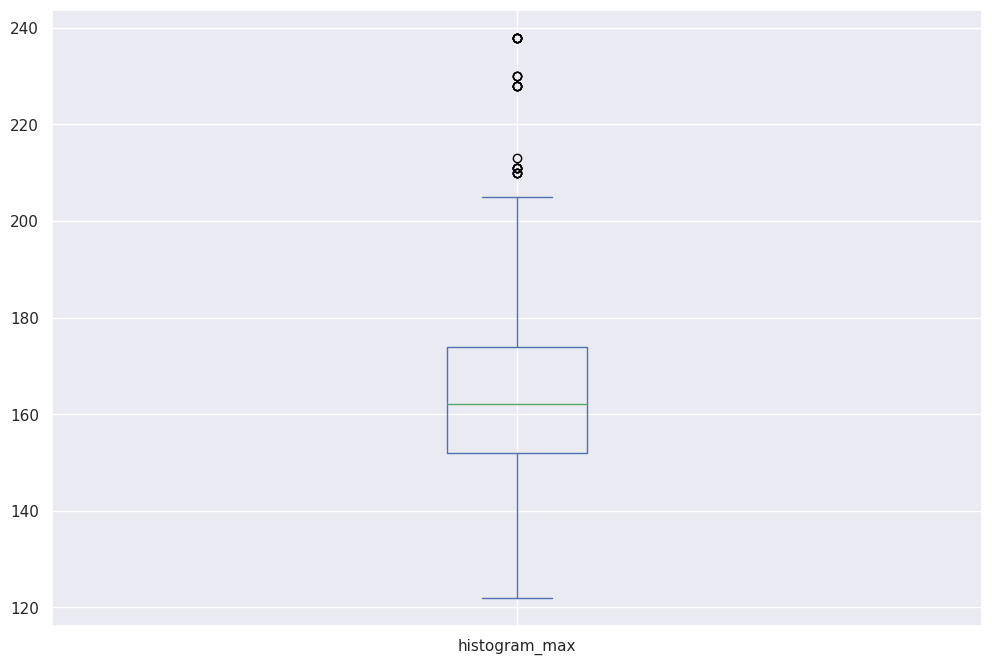

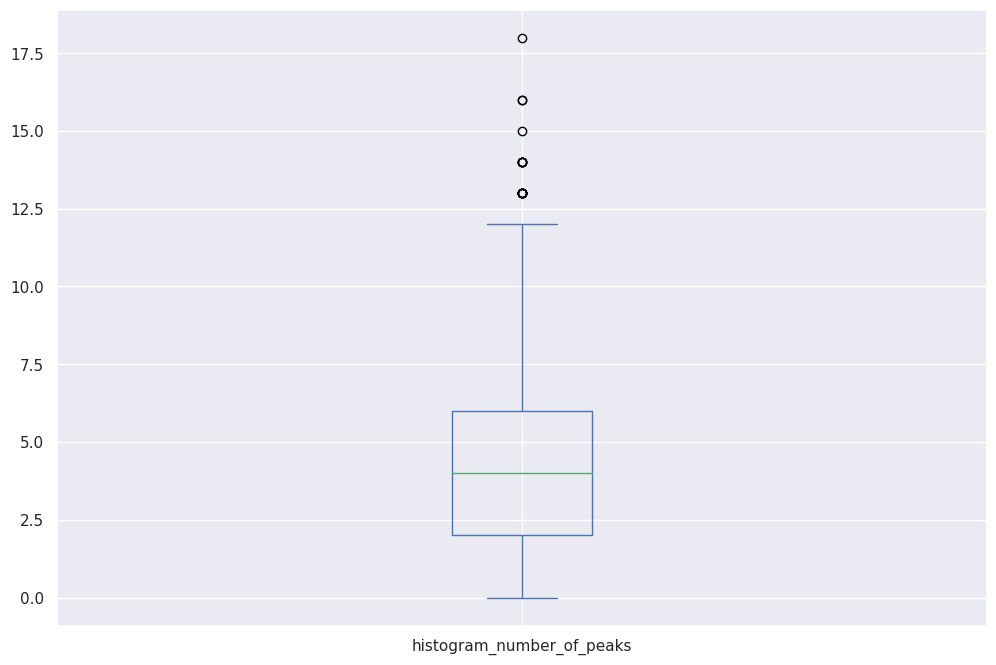

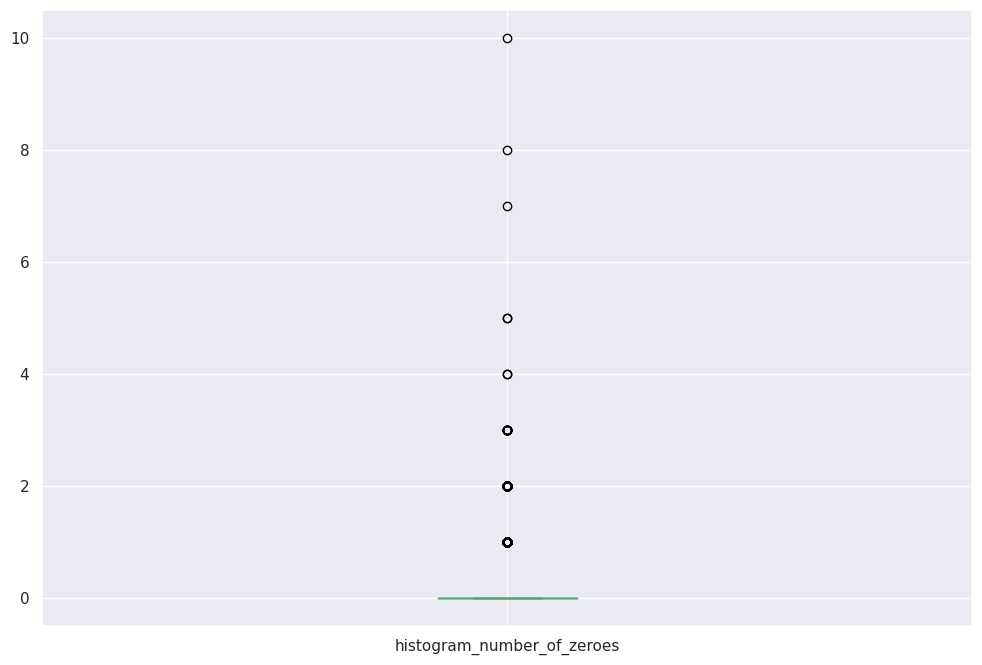

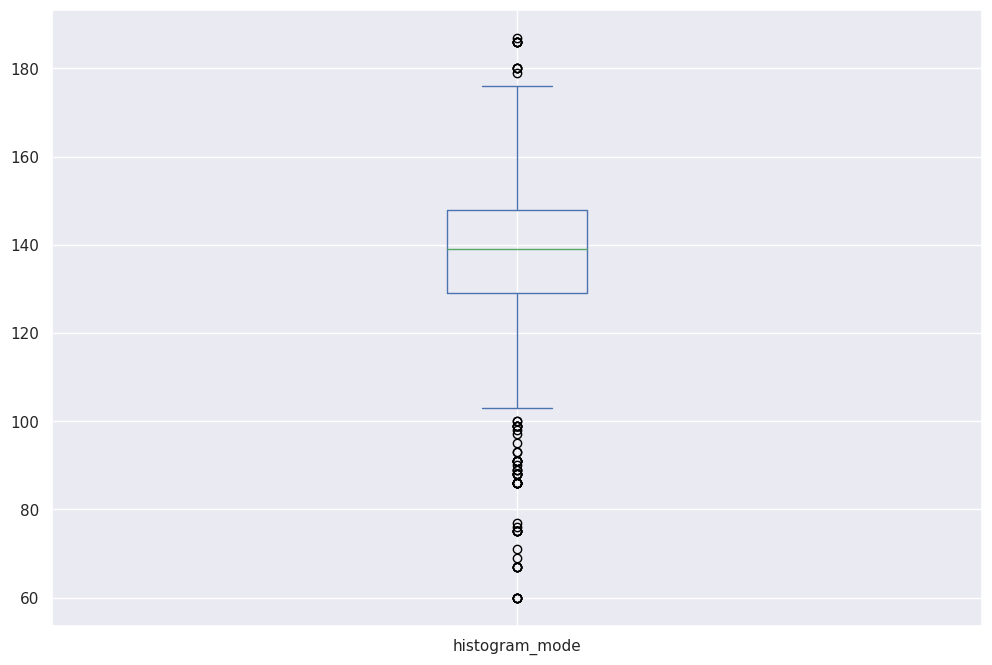

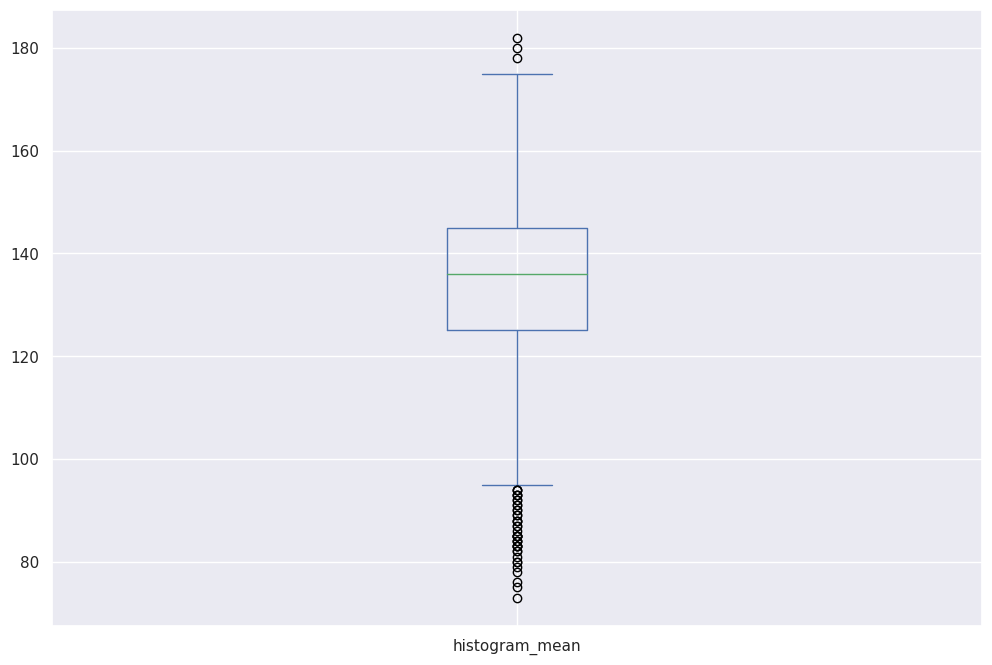

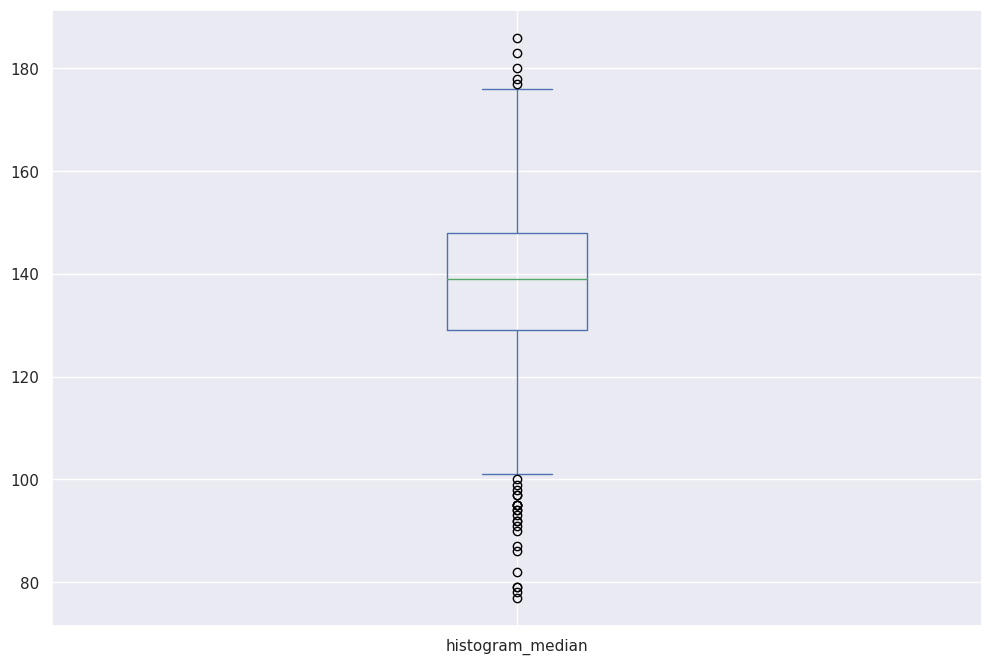

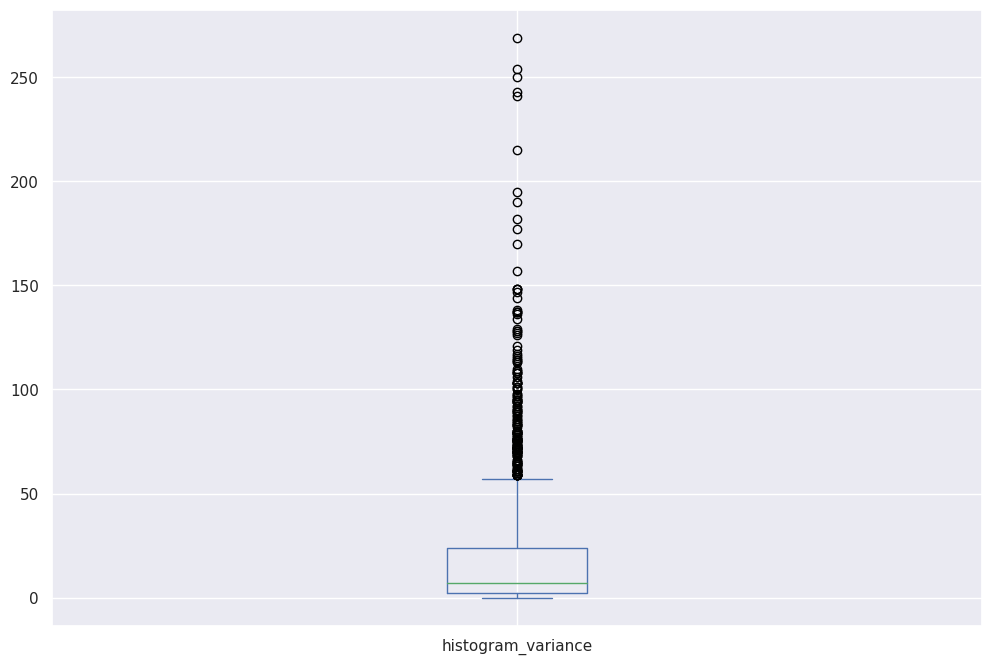

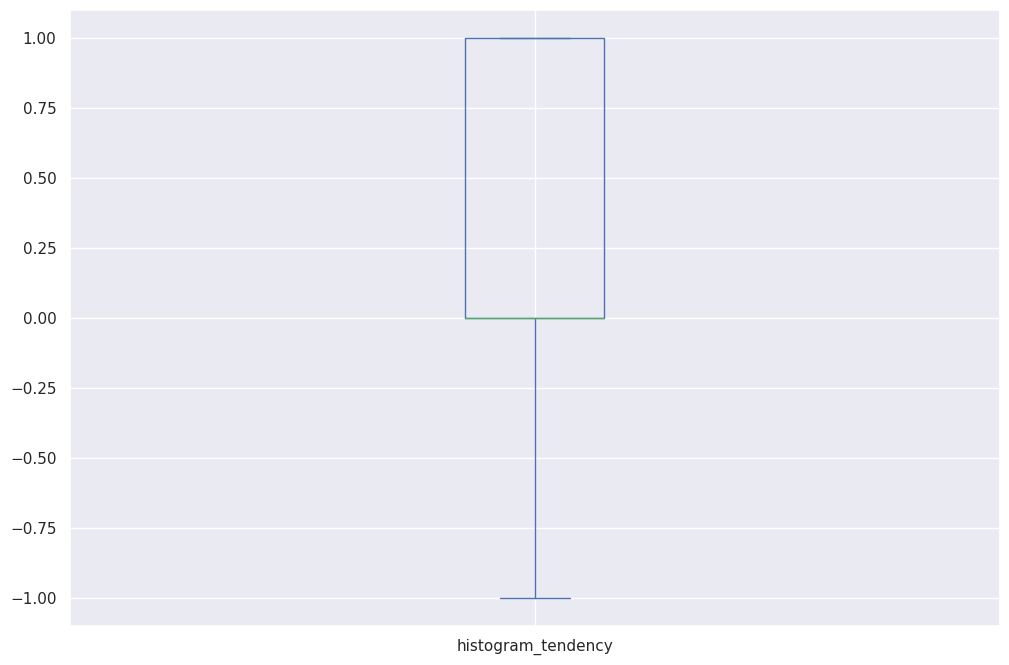

In [15]:
for feature in features_list:
    sns.set(rc={'figure.figsize':(12, 8)})
    df[feature].plot(kind='box')
    plt.show()
    print('')

Видим, что большинство признаков имеют экстремальные относительно общей массы значения. Однако вполне возможно, что они не являются ошибочными, так как в наших данных присутствует паталогический класс здоровья, параметры которого будут сильно отдалены по своим значениям от аналогичных параметров у здорового и пограничного классов.

Смотрим количество пропусков по столбцам.

In [16]:
pd.DataFrame(
    round(
        df.isna().mean() * 100,
    )
).style.background_gradient('coolwarm')

,0
baseline value,0.000000
accelerations,0.000000
fetal_movement,0.000000
uterine_contractions,0.000000
light_decelerations,0.000000
severe_decelerations,0.000000
prolongued_decelerations,0.000000
abnormal_short_term_variability,0.000000
mean_value_of_short_term_variability,0.000000
percentage_of_time_with_abnormal_long_term_variability,0.000000


Пропусков нет.

Отдельно смотрим баланс классов целевого признака.

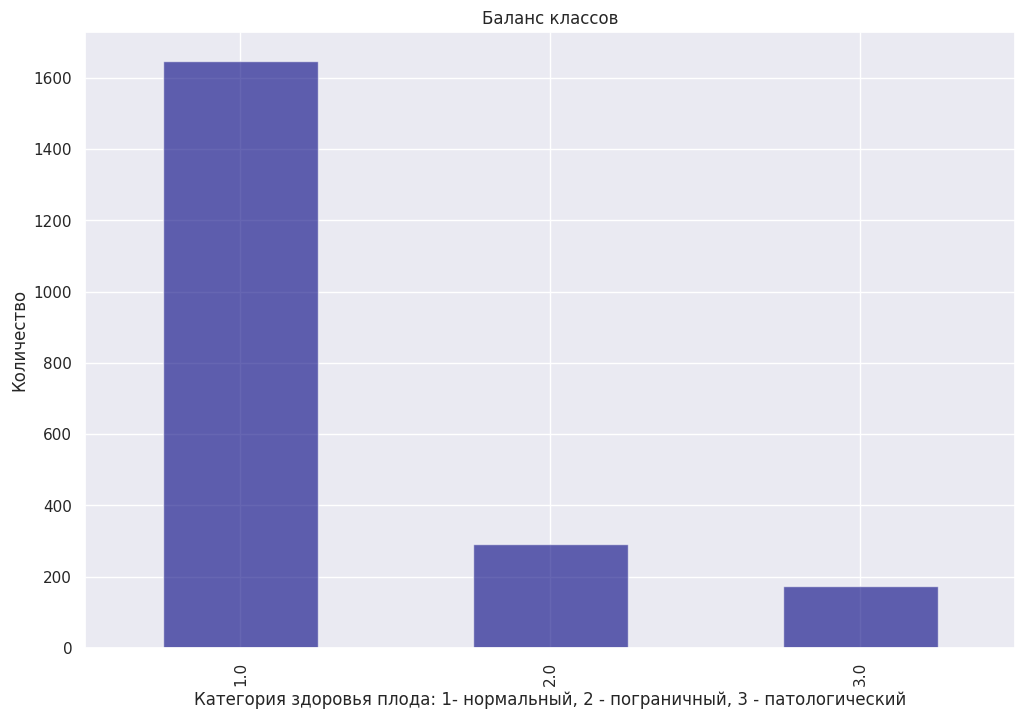

In [17]:
class_counts = df['fetal_health'].value_counts()

sns.set(rc={'figure.figsize': (12, 8)})
class_counts.plot(kind='bar', color='navy', alpha=0.6)
plt.xlabel(
    'Категория здоровья плода: 1- нормальный, 2 - пограничный, 3 - патологический'
)
plt.ylabel('Количество')
plt.title('Баланс классов')
plt.show()

Видим явный дисбаланс.

## Выводы по разделу.
- Данные загружены и изучены.
- Обнаружены и удалены дубликаты.
- Пропуски в данных не обнаружены.
- Построены гистограммы распределения и диаграммы размаха.
- Наблюдается ощутимый дисбаланс классов целевого признака, это надо будет учесть далее.

# Корреляции признаков.

Строим матрицу корреляций.

<Axes: >

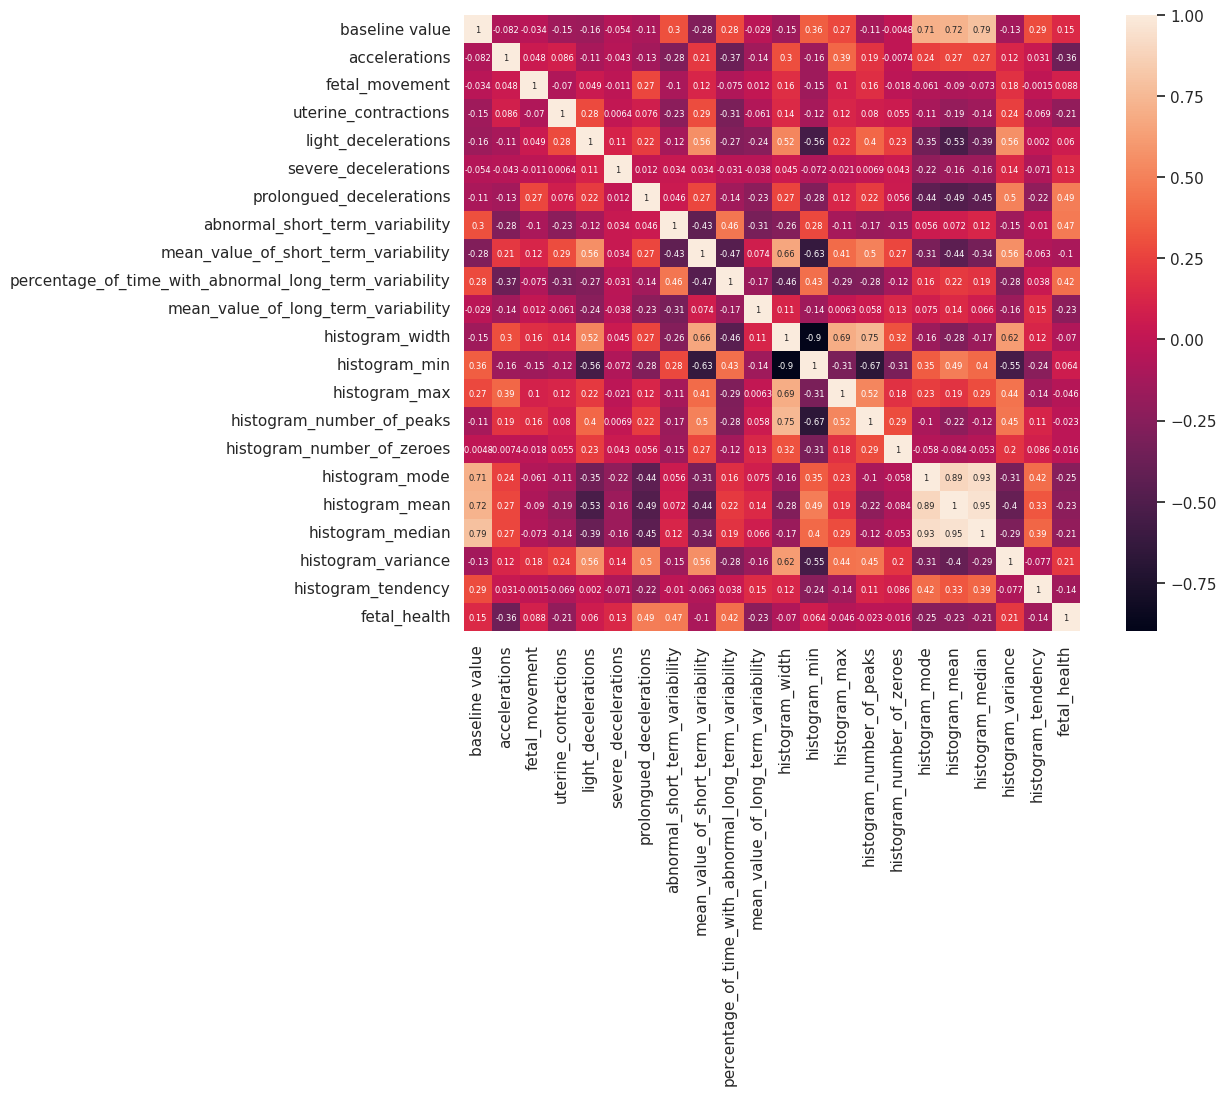

In [18]:
correlations = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, square = True, annot = True, annot_kws={'fontsize': 6})

Смотрим, как каждый из входных признаков влияет на целевой.

In [19]:
corr_target = abs(correlations['fetal_health'])
corr_target.sort_values(ascending = False)

fetal_health                                              1.000000
prolongued_decelerations                                  0.486752
abnormal_short_term_variability                           0.469671
percentage_of_time_with_abnormal_long_term_variability    0.421634
accelerations                                             0.363947
histogram_mode                                            0.253612
histogram_mean                                            0.230243
mean_value_of_long_term_variability                       0.225685
histogram_median                                          0.208334
histogram_variance                                        0.208171
uterine_contractions                                      0.205117
baseline value                                            0.146077
histogram_tendency                                        0.135573
severe_decelerations                                      0.132408
mean_value_of_short_term_variability                      0.10

## Выводы по разделу.

- Многие из входных признаков связаны между собой. Это нормально, учитывая, что все они являются показателями КТГ, и изменение одного из них часто ведёт к изменению другого.
- Самая сильная корреляция у входных признаков между средними (среднеарифметическое, медиана и мода) показателями гистограммы. Бороться с мультиколлинеарностью здесь особого смысла не вижу, потому что бустинговые модели к ней устойчивы. Поэтому оставлю все имеющиеся признаки.
- Исходя из значений коэффициента Пирсона, можно предположить, что наиболее коррелируют с целевым признаком пролонгированная децелерация (prolongued_decelerations), вариабельность ритма STV (abnormal_short_term_variability) и процент времени с вариабельностью LTV (percentage_of_time_with_abnormal_long_term_variability).

# Построение моделей. Кросс-валидация на тренировочной выборке.

Разделим данные на тренировочную и тестовую выборки.

In [20]:
train, test = train_test_split(
    df, train_size=0.7, random_state=42, stratify=df['fetal_health'], shuffle=True
)

Отделим целевой признак от остальных.

In [21]:
X = features_list
y = ['fetal_health']

Создаём объекты scorer для нашей метрики и kfold для кросс-валидации.

In [22]:
scorer = make_scorer(fbeta_score, beta=0.5, average='weighted')

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=RND_STATE)

Смотрим значение метрики на кросс-валидации для CatBoost.

In [24]:
model_cb = CatBoostClassifier(
        auto_class_weights='Balanced',
        random_seed=RND_STATE,
        loss_function='MultiClass',
        verbose=100,
        task_type='GPU')

cross_val_scores_cb = cross_val_score(
        model_cb, train[X], train[y], cv=kf, scoring=scorer)

fbeta_score_train_cb = cross_val_scores_cb.mean()

print(f'Средняя величина метрики F-Beta на кросс-валидации: {fbeta_score_train_cb}')

Learning rate set to 0.06717
0:	learn: 1.0139956	total: 33.7ms	remaining: 33.6s
100:	learn: 0.1312408	total: 2.3s	remaining: 20.4s
200:	learn: 0.0735296	total: 5.33s	remaining: 21.2s
300:	learn: 0.0492893	total: 10.5s	remaining: 24.3s
400:	learn: 0.0363211	total: 12.9s	remaining: 19.3s
500:	learn: 0.0278212	total: 15.4s	remaining: 15.4s
600:	learn: 0.0219173	total: 18.3s	remaining: 12.1s
700:	learn: 0.0180033	total: 23.1s	remaining: 9.87s
800:	learn: 0.0151977	total: 26.4s	remaining: 6.55s
900:	learn: 0.0131849	total: 27s	remaining: 2.97s
999:	learn: 0.0116663	total: 27.6s	remaining: 0us
Learning rate set to 0.06717
0:	learn: 1.0089418	total: 6.24ms	remaining: 6.23s
100:	learn: 0.1214627	total: 510ms	remaining: 4.54s
200:	learn: 0.0660915	total: 1.03s	remaining: 4.08s
300:	learn: 0.0426992	total: 1.52s	remaining: 3.54s
400:	learn: 0.0303625	total: 2.07s	remaining: 3.09s
500:	learn: 0.0227479	total: 2.61s	remaining: 2.6s
600:	learn: 0.0178641	total: 3.15s	remaining: 2.09s
700:	learn: 0.

Приводим тренировочную выборку в подходящий для LightGBM вид и считаем его значение метрики.

In [25]:
train_y_lgbm = train[y]['fetal_health']

In [26]:
model_lgbm = lgbm.LGBMClassifier(
    random_state=RND_STATE,
    class_weight='balanced',
    objective='multiclass',
    verbosity=-1,
    tree_method='gpu_hist'
)

cross_val_scores_lgbm = cross_val_score(
    model_lgbm, train[X], train_y_lgbm, cv=kf, scoring=scorer)

fbeta_score_train_lgbm = cross_val_scores_lgbm.mean()

print(f'Средняя величина метрики F-Beta на кросс-валидации: {fbeta_score_train_lgbm}')

Средняя величина метрики F-Beta на кросс-валидации: 0.9461278847321768


Аналогично поступаем для XGBoost.

In [27]:
mapping = {1:0, 2:1, 3:2}
train_y_xgb = train_y_lgbm.replace(mapping)

In [28]:
model_xgb = XGBClassifier(
        random_state=RND_STATE,
        objective='multi:softmax',
        verbosity=1
)

cross_val_scores_xgb = cross_val_score(
        model_xgb, train[X], train_y_xgb, cv=kf, scoring=scorer
)

fbeta_score_train_xgb = cross_val_scores_xgb.mean()

print(f'Средняя величина метрики F-Beta на кросс-валидации: {fbeta_score_train_xgb}')

Средняя величина метрики F-Beta на кросс-валидации: 0.9441915117159736


Сравниваем получившиеся значения.

In [29]:
data = {
    'CatBoost': [fbeta_score_train_cb],
    'LightGBM': [fbeta_score_train_lgbm],
    'XGBoost': [fbeta_score_train_xgb],
}
cv_results = pd.DataFrame(data)
cv_results.index = ['F-Beta']
cv_results


,CatBoost,LightGBM,XGBoost
F-Beta,0.942264,0.946128,0.944192


## Выводы по разделу.

- Данные были разбиты на тренировочную, валидационную и тестовую выборки.
- Все три модели были обучены на тренировочных данных с кросс-валидацией, значение метрики посчитано.
- С минимальным отрывом лучший результат показала модель LigthGBM, её и будем обучать на тестовых данных.

# Проверка выбранной модели на тестовых данных.

Обучаем модель на тестовых данных, получаем предсказания.

In [30]:
model_lgbm.fit(train[X], train_y_lgbm)
predictions = model_lgbm.predict(test[X])

Считаем значение метрики на тестовой выборке.

In [31]:
fbeta_score_test_lgbm = fbeta_score(test[y], predictions, average='weighted', beta=0.5)

print(f'Величина метрики F-Beta на тестовой выборке: {fbeta_score_test_lgbm}')

Величина метрики F-Beta на тестовой выборке: 0.9578726072340522


Смотрим матрицу ошибок.

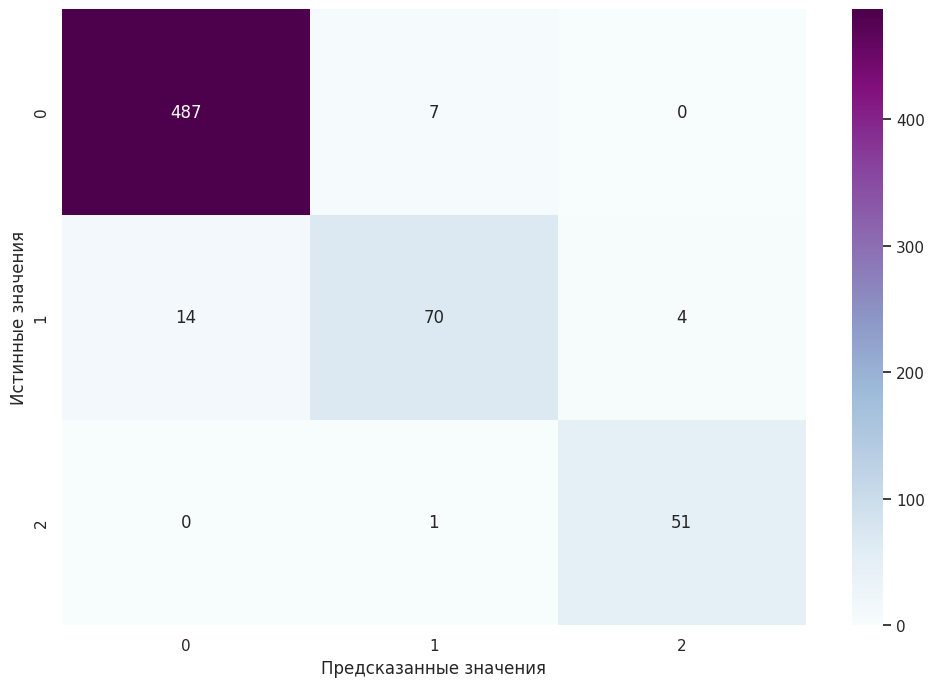

In [32]:
cm = confusion_matrix(test[y], predictions)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True,  fmt='d', cmap='BuPu')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()

Определяем важность признаков для модели.

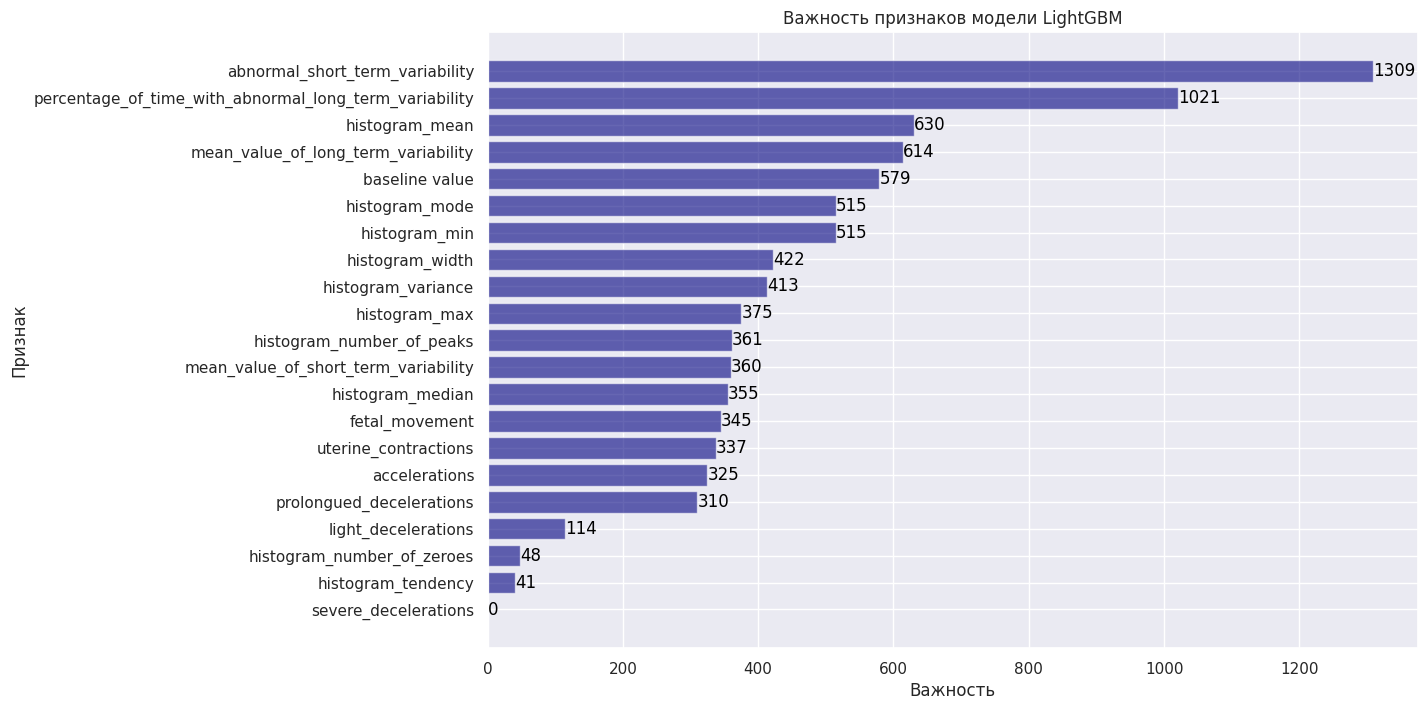

In [33]:
feature_importances = model_lgbm.feature_importances_

feature_importances = [
    (importance, feature)
    for importance, feature in zip(feature_importances, train[X].columns)
]
feature_importances.sort(reverse=False)

importances_sorted = [importance for importance, feature in feature_importances]
features_sorted = [feature for importance, feature in feature_importances]

sns.set(rc={'figure.figsize': (12, 8)})
plt.barh(range(len(importances_sorted)), importances_sorted, color='navy', alpha=0.6)
plt.yticks(range(len(importances_sorted)), features_sorted, rotation=0)
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.title('Важность признаков модели LightGBM')

for i, v in enumerate(importances_sorted):
    plt.text(v, i, str(v), color='black', ha='left', va='center')

plt.show()


## Выводы по разделу.
- Выбранная модель обучена на тестовой выборке данных, получены её предсказания.
- Значение F-Beta на тестовых данных 0.9578, что совсем немного, но выше того, что мы получили на тренировочных данных.
- Построена матрица ошибок модели.
- Определена важность признаков для модели.

# Общие выводы.

Учитывая, что по итогу предсказания моделью плод может быть отнесён к одному из трёх классов здоровья (где третий является самым опасным), фатальной ошибкой, в перспективе ведущей к смерти ребёнка, в данном случае является ситуация, где неверно определён класс паталогического плода (особенно если он отнесён к нормальному классу) . Другие ошибки в определении класса, хотя и являются также нежелательными, но скорее всего не приведут к такому трагическому результату.


Согласно матрице ошибок, 51 из 52 патологических плодов верно распознан нашей моделью, а оставшийся один отнесён к пограничному классу, что в перспективе предполагает дальнейшие медицинские исследования и также верное установление диагноза.


Таким образом считаю использование нашей модели в целом адекватным решением в рамках данного вопроса. Однако для её реального применения модель должна быть подвергнута дальнейшему улучшению, дабы ещё увеличить количество объектов, чей класс был распознан верно. Провести оптимизацию модели можно, например, путём исключения входных признаков, признанных моделью бесполезными или малополезными.